# Predicción de Precios de Venta de Inmuebles Bs As

# Introducción
Se presenta un Dataset que contiene los precios de Venta de inmuebles para una inmobiliaria que opera en Capital Federal y Gran Buenos Aires.

# Definición de los objetivos del trabajo:

Efectuar un análisis exploratorios para comprender la información disponible respecto a Publicaciones de Ventas de inmuebles de 2019 de una inmobiliaria que opera en Capital Federal y Gran Buenos Aires.

Objetivo general del trabajo

* Predecir el precio de los departamentos del barrio de Palermo, Capital Federal. 

Objetivos específicos:
1. Efectuar un análisis exploratorio para comprender la información disponible respecto a Publicaciones de Ventas de inmuebles de 2019 de una inmobiliaria que opera en Capital Federal y Gran Buenos Aires.
2. Definir las variables de estudio relevantes y la categorización necesaria para obtener una buena capacidad de predicción
3. Implementar algoritmos de predicción, optimizarlos y verificar su capacidad de predicción.


##### Dataset adicionales incorporados - Fuente:

Precios de terrenos por barrio: https://data.buenosaires.gob.ar/dataset
Delitos Registrados (denunciados) en CABA durante 2019: https://data.buenosaires.gob.ar/dataset/delitos

In [1]:
# Librerías comunes:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# Librerías para Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn import tree


from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from math import sqrt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

import folium
from folium.plugins import HeatMap
from collections import Counter


In [2]:
# Crear una función para calcular porcentajes:
def porcentajes (df, columna):
    porcentaje = df[columna].value_counts() / df[columna].count()
    return porcentaje

In [3]:
# Función para encontrar outliers:

def outlier_treatment(datacolumn):
    sorted(datacolumn) # Ordernar las filas para poder encontrar los cuartiles
    Q1, Q3 = np.nanpercentile(datacolumn,[25,75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5*IQR)
    upper_range = Q3+ (1.5*IQR)
    return lower_range, upper_range

In [4]:
# Crear una función para el filtrado de datos outliers superiores por el método del rango intercuartílico:

def filtrar_iqr_superior(dataset,columna):
    q3=dataset[columna].quantile(0.75)
    q1=dataset[columna].quantile(0.25)
    iqr=q3-q1
    limite_superior=q3+(1.5*iqr)
    dataset=dataset[(dataset[columna] < limite_superior) ]
    return dataset

In [5]:
# Función para detectar múltiples outliers:

from collections import Counter

def detect_outliers(df, n, features):
    outliers_indices = [] #create a empty list to keep track of the passenger row number.
    for col in features:
        # 1st quartile (25%)
        Q1 = np.nanpercentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.nanpercentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step)
                              | (df[col] > Q3 + outlier_step)].index
        
        #print(df[(df[col] < Q1 - outlier_step)
                              #| (df[col] > Q3 + outlier_step)].index)
        print(col,Q1-outlier_step,Q3+outlier_step)
        # append the found outlier indices for col to the list of outlier indices
        outliers_indices.extend(outlier_list_col)
        
    #print(outliers_indices)
    
    # select observations containing more than 2 outliers
    outliers_indices = Counter(outliers_indices)
    multiple_outliers = list(k for k, v in outliers_indices.items() if v > n)
    #print(outliers_indices)
    
    return multiple_outliers

In [6]:
def test_normal (column):
    from scipy import stats
    k2, p = stats.normaltest(column)
    alpha = 0.05
# Hipótesis nula: La distribución es normal
    if p < alpha: 
        resultado = ("Se rechaza la hipótesis nula. La distribución no es normal")
    else:
        resultado = ("Se acepta la hipótesis nula. La distribución es normal")
    return resultado

In [7]:
# Definir una función para % de datos faltantes
def porcentaje_faltante (dataset, columna):
    porcentaje_faltante = dataset[columna].isna().sum() / dataset[columna].count()
    return porcentaje_faltante

In [8]:
# Función para graficar con DBSCAN
def plot_DBSCAN(X1,labels_1,db,n_clusters_1):
    # Armamos una mascara, con unos en los datos que son CORES.
    core_samples_mask_1 = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask_1[db.core_sample_indices_] = True
    # Plot result

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X1[class_member_mask & core_samples_mask_1]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X1[class_member_mask & ~core_samples_mask_1]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    plt.title('Estimated number of clusters: %d' % n_clusters)
    plt.show()
    return

In [9]:
# Definir una función para verificar cuál es el mejor grado polinómico a aplicar:
def get_models(n):
    from sklearn.pipeline import Pipeline
    models = dict()
    for d in range(1,n):
        # define the pipeline
        trans = PolynomialFeatures(degree=d)
        model = Ridge()
        models[str(d)] = Pipeline(steps=[('t', trans), ('m', model)])
    return models
 
# Definir una función para efectuar la cross validation del modelo
def evaluate_model(model):
    scores = cross_val_score(model, X, y, cv=5)
    return scores

In [10]:
# Iniciar cargando el Dataset
df = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [11]:
# Describir el nombre de cada una de las variables:
df.columns.values

array(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2',
       'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'title', 'description',
       'property_type', 'operation_type'], dtype=object)

In [12]:
# Describir el tipo de caracteres almacenados en cada variable:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

### Primera aproximación al DataSet:
El Dataset cuenta con 146660 instancias, y 19 caraterísticas, de las cuales 8 son variables continuas y 11 categóricas.
La variable dependiente es el precio, mientras que el resto son variables independientes que será necesario analizar para terminar cuáles son influyentes en la determinación del precio de la propiedad.

#### 1. Análisis de datos faltantes
Al iniciar con el análisis de datos, es importante conocer si existen registros con valores nulos o faltantes. Estos, en el caso de ser significativos, pueden modificar la capacidad de predicción.
Existen diversos métodos de gestión de datos faltantes, dependiendo del volumen y tipo de distribución de cada una de las variables donde se presenta.

In [13]:
# Verificar si existen valores nulos o faltantes

df.isna().sum()

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

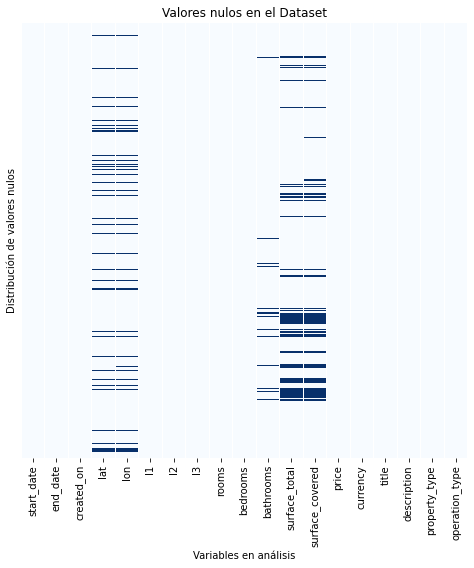

In [14]:
# Gráficar la distribución de los datos faltantes:

plt.figure(figsize = (8,8))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'Blues')

plt.title("Valores nulos en el Dataset")
plt.xlabel("Variables en análisis")
plt.ylabel("Distribución de valores nulos")
plt.xticks(rotation=90);

* Las variables superficie total y superficie cubierta presentan la mayor concentración de valores nulos. 
* Las variables latitud y longitud presentan volumen similar de valores nulos, con una distribución uniforme de los mismos.  

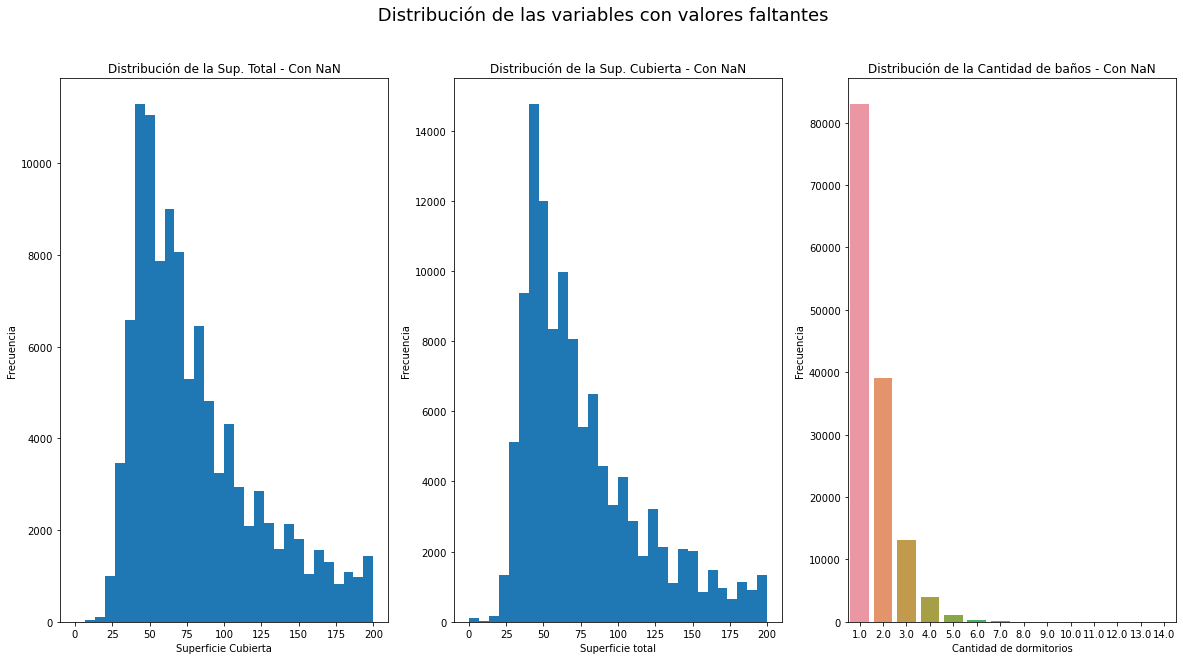

In [15]:
# Graficar las distribuciones de las variables con valores faltantes, para analizar el correcto modelo de imputación

f, axes = plt.subplots(1, 2 ,figsize=(20,10))
plt.suptitle (" Distribución de las variables con valores faltantes", fontsize = 18)

plt.subplot(1,3,1)
df.surface_total.plot.hist(bins = 30, range = (0, 200))
plt.title('Distribución de la Sup. Total - Con NaN')
plt.xlabel("Superficie Cubierta")
plt.ylabel("Frecuencia")

plt.subplot(1,3,2)
df.surface_covered.plot.hist(bins = 30, range = (0, 200))
plt.title('Distribución de la Sup. Cubierta - Con NaN')
plt.xlabel("Superficie total")
plt.ylabel("Frecuencia")



plt.subplot(1,3,3)
sns.countplot(data = df, x = "bathrooms");
plt.title("Distribución de la Cantidad de baños - Con NaN")
plt.xlabel("Cantidad de dormitorios")
plt.ylabel("Frecuencia")


plt.show();

In [16]:
# Cálculo de la media y mediana de cada una de las variables para verificar la distribución con estadística descriptiva:

print ("Mediana de la sup total vs" , df.surface_total.median(), "Media de la sup total" , df.surface_total.mean())
print ("Mediana de la sup. cubierta vs", df.surface_covered.median(), "Media de la sup. cubierta", df.surface_covered.mean())
print ("Mediana de la cantidad de baños vs", df.bathrooms.median(), "Media de la cantidad de baños", df.bathrooms.mean())
print ("Mediana de la Latitud vs", df.lat.median(), "Media de la Latitud", df.lat.mean())
print ("Mediana de la Longitud vs", df.lon.median(), "Media de la Longitud", df.lon.mean())

Mediana de la sup total vs 78.0 Media de la sup total 216.872888141882
Mediana de la sup. cubierta vs 68.0 Media de la sup. cubierta 112.81801097196232
Mediana de la cantidad de baños vs 1.0 Media de la cantidad de baños 1.599994314264799
Mediana de la Latitud vs -34.6009428 Media de la Latitud -34.60489632652645
Mediana de la Longitud vs -58.443262 Media de la Longitud -58.46530367625129


In [17]:
# Verificar si la distribuciones son normales:
print ("Distribución de la superficie total: " , test_normal (df.surface_total))
print ("Distribución de la superficie cuberta: " , test_normal (df.surface_covered))
print ("Distribución de los baños: " , test_normal (df.bathrooms))
print ("Distribución de la Latitud: " , test_normal (df.lat))
print ("Distribución de los Longitud: " , test_normal (df.lon))

Distribución de la superficie total:  Se acepta la hipótesis nula. La distribución es normal
Distribución de la superficie cuberta:  Se acepta la hipótesis nula. La distribución es normal
Distribución de los baños:  Se acepta la hipótesis nula. La distribución es normal
Distribución de la Latitud:  Se acepta la hipótesis nula. La distribución es normal
Distribución de los Longitud:  Se acepta la hipótesis nula. La distribución es normal


In [18]:
# Cálculo del porcentaje de valores nulos 
print ("Faltantes en Sup. Total", porcentaje_faltante (df, "surface_total"))
print ("Faltantes en Sup. Cubierta", porcentaje_faltante (df, "surface_covered"))
print ("Faltantes en baños", porcentaje_faltante (df, "bathrooms"))
print ("Faltantes en Latitud", porcentaje_faltante (df, "lat"))
print ("Faltantes en Longitud", porcentaje_faltante (df, "lon"))

Faltantes en Sup. Total 0.16274091633434548
Faltantes en Sup. Cubierta 0.1728483917918206
Faltantes en baños 0.04233740574117112
Faltantes en Latitud 0.07258565839031704
Faltantes en Longitud 0.07285242975545168


In [19]:
# Definir el modelo imputer:

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Elegir las variables donde Se efectuará el reemplazo:

df["surface_total"] = imputer.fit_transform(df["surface_total"].values.reshape(-1, 1))
df["surface_covered"] = imputer.fit_transform(df["surface_covered"].values.reshape(-1, 1))
df["bathrooms"] = imputer.fit_transform(df["bathrooms"].values.reshape(-1, 1))
df["lat"] = imputer.fit_transform(df["lat"].values.reshape(-1, 1))
df["lon"] = imputer.fit_transform(df["lon"].values.reshape(-1, 1))

In [20]:
#Verificar la correcta aplicación de la imputación:

df.isna().sum()

start_date         0
end_date           0
created_on         0
lat                0
lon                0
l1                 0
l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
currency           0
title              0
description        0
property_type      0
operation_type     0
dtype: int64

En Este análisis, la variable "Latitud" y "Longitud" no serán relevante porque tenemos información específica de la zona geográfica, por lo que pueden reemplazarse directamente. Por ello, se limita el análisis a las variables: Superficie total, cubierta y cantidad de baños.

Se grafica la distribución de las variables "surface_total" y "surface_covered". Se efectúa un Countplot de la variable "Bathrooms"

####  2. Análisis de valores atípicos (outliers):
Un outlier es una observación anormal, extrema que en una muestra estadística que no es consistente con el resto de los datos y que puede afectar potencialmente a la estimación de los parámetros del mismo.


In [21]:
# Efectuar una descripción de las variables continuas:
df.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,146660.000000,1.466600e+05
mean,-34.604629,-58.463807,3.079817,1.983240,1.575624,197.435797,106.212962,2.412211e+05
std,0.452302,0.469425,1.416352,1.151304,0.879091,1890.252244,846.753777,3.185195e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.624216,-58.497253,2.000000,1.000000,1.000000,56.000000,50.000000,1.110000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,-34.577975,-58.411457,4.000000,3.000000,2.000000,124.000000,98.000000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


* La amplia diferencia entre los valores mínimos y el 25% de los datos, y del 75% de los datos con los valores máximos, indica la prescencia de valores extremos tanto máximos como mínimos.

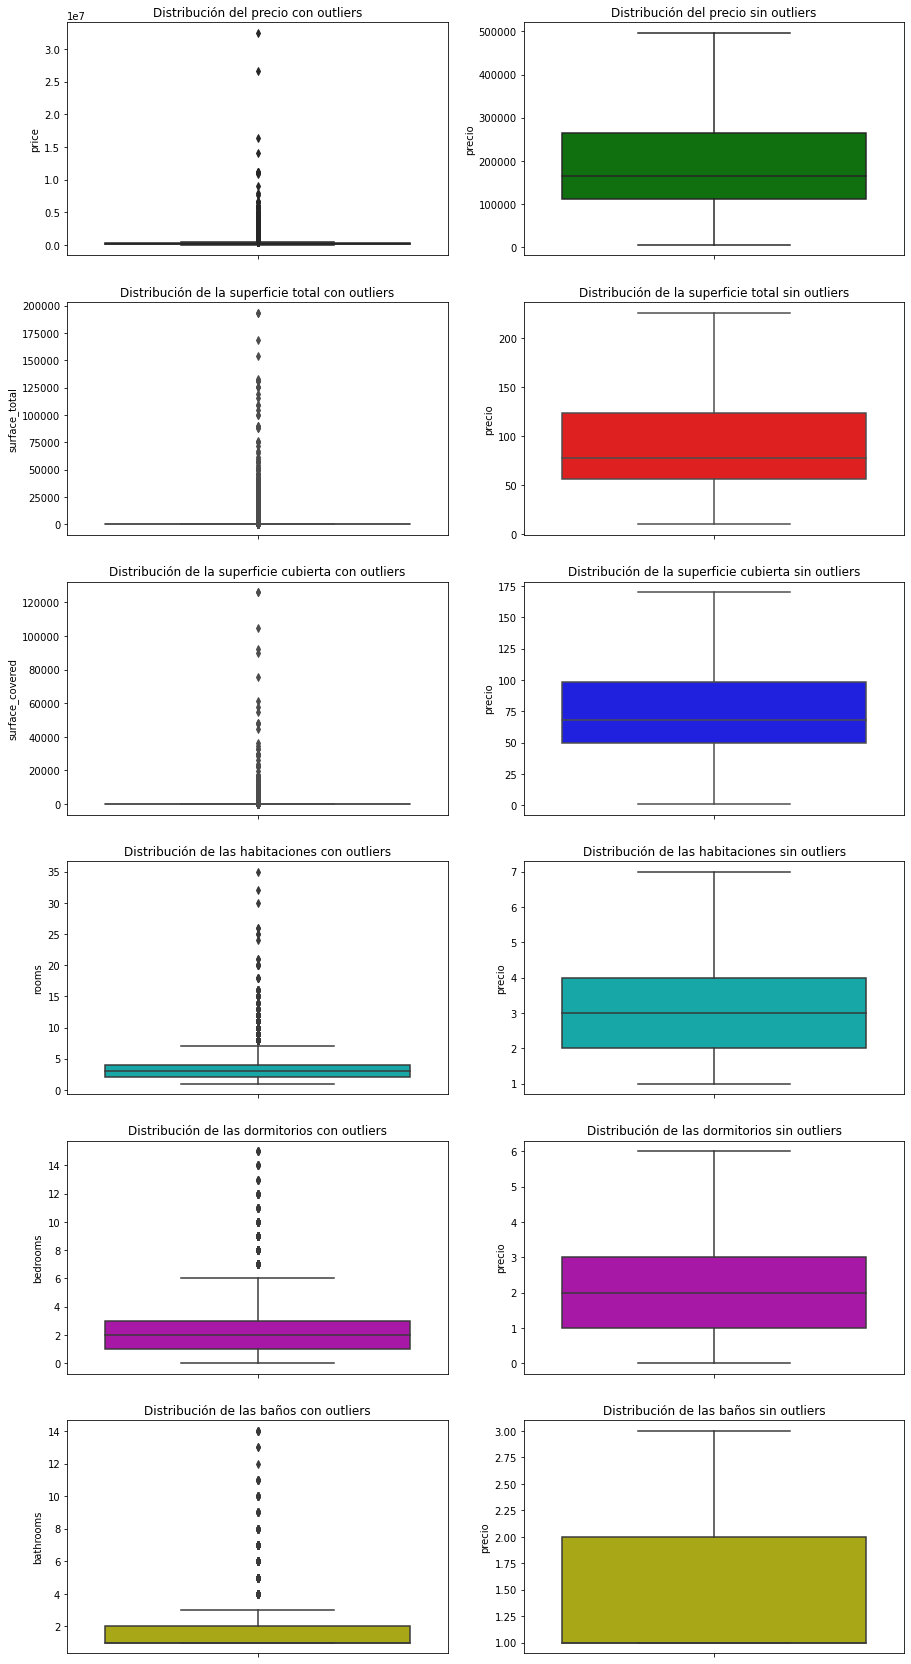

In [22]:
# Graficar las variables con y sin outliers para la comparación


plt.figure(figsize = (15,30))

plt.subplot(6,2,1) #
sns.boxplot(data = df, y = "price", color = "g")
plt.title("Distribución del precio con outliers")


plt.subplot(6,2,2) #
sns.boxplot(data = df, y = "price", color = "g", showfliers = False)
plt.title("Distribución del precio sin outliers")
plt.ylabel("precio")



plt.subplot(6,2,3) #
sns.boxplot(data = df, y = "surface_total", color = "r")
plt.title("Distribución de la superficie total con outliers")


plt.subplot(6,2,4) #
sns.boxplot(data = df, y = "surface_total", color = "r", showfliers = False)
plt.title("Distribución de la superficie total sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,5) #
sns.boxplot(data = df, y = "surface_covered", color = "b")
plt.title("Distribución de la superficie cubierta con outliers")


plt.subplot(6,2,6) #
sns.boxplot(data = df, y = "surface_covered", color = "b", showfliers = False)
plt.title("Distribución de la superficie cubierta sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,7) #
sns.boxplot(data = df, y = "rooms", color = "c")
plt.title("Distribución de las habitaciones con outliers")


plt.subplot(6,2,8) #
sns.boxplot(data = df, y = "rooms", color = "c", showfliers = False)
plt.title("Distribución de las habitaciones sin outliers")
plt.ylabel("precio")

plt.subplot(6,2,9) #
sns.boxplot(data = df, y = "bedrooms", color = "m")
plt.title("Distribución de las dormitorios con outliers")


plt.subplot(6,2,10) #
sns.boxplot(data = df, y = "bedrooms", color = "m", showfliers = False)
plt.title("Distribución de las dormitorios sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,11) #
sns.boxplot(data = df, y = "bathrooms", color = "y")
plt.title("Distribución de las baños con outliers")


plt.subplot(6,2,12) #
sns.boxplot(data = df, y = "bathrooms", color = "y", showfliers = False)
plt.title("Distribución de las baños sin outliers")
plt.ylabel("precio");


Las gráficas permiten observar como en todas las variables se presentan valores atípicos, donde las variables precio, superficie total y cubierta, son las que presentan mayor diferencia entre el rango máximo y el valor que representa el 75% del resto de los datos. Esto genera sesgos que pueden incrementar el error de predicción de un algortimo,

In [23]:
# Analizar los rangos máximos y mínimos para que un registro sea considerado outlier:


print('Rango mínimo y máximo para Superficie total:',outlier_treatment(df.surface_total), sep = '\n')
print('Rango mínimo y máximo para Superficie cubierta:',outlier_treatment(df.surface_covered), sep = '\n')
print('Rango mínimo y máximo para precio:',outlier_treatment(df.price), sep = '\n')
print('Rango mínimo y máximo para cantidad de habitaciones:',outlier_treatment(df.rooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de dormitorios:',outlier_treatment(df.bedrooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de baños:',outlier_treatment(df.bathrooms), sep = '\n')

Rango mínimo y máximo para Superficie total:
(-46.0, 226.0)
Rango mínimo y máximo para Superficie cubierta:
(-22.0, 170.0)
Rango mínimo y máximo para precio:
(-120000.0, 496000.0)
Rango mínimo y máximo para cantidad de habitaciones:
(-1.0, 7.0)
Rango mínimo y máximo para cantidad de dormitorios:
(-2.0, 6.0)
Rango mínimo y máximo para cantidad de baños:
(-0.5, 3.5)


In [24]:
# Analizar cuántos outliers se eliminarían tomando todos los casos de outliers (eliminar el dato si cumple al menos con una de las condiciones)


# Si elegimos como outlier que cumpla con una sola de las condiciones dadas:
Outliers_to_drop = detect_outliers(df, 1, ["surface_total", "surface_covered", "price", "rooms", "bedrooms","bathrooms"])
print ("Cantidad de Outliers a eliminar", len(Outliers_to_drop))


surface_total -46.0 226.0
surface_covered -22.0 170.0
price -120000.0 496000.0
rooms -1.0 7.0
bedrooms -2.0 6.0
bathrooms -0.5 3.5
Cantidad de Outliers a eliminar 13649


In [25]:
# Si elegimos con outlier que cumpla con 2 de las las condiciones dadas (más de una variable presente condición de outlier):

Outliers_to_drop_2 = detect_outliers(df, 2, ["surface_total", "surface_covered", "price", "rooms", "bedrooms","bathrooms"])
print ("Cantidad de Outliers a eliminar", len(Outliers_to_drop_2))
# Si elegimos con outlier que cumpla con 2 de las las condiciones dadas (más de una variable presente condición de outlier):



surface_total -46.0 226.0
surface_covered -22.0 170.0
price -120000.0 496000.0
rooms -1.0 7.0
bedrooms -2.0 6.0
bathrooms -0.5 3.5
Cantidad de Outliers a eliminar 6047


In [26]:
# Eligiendo solo precio, superficie total y superficie cubierta y que cumpla cualquiera de las 3 condiciones:

Outliers_to_drop_3 = detect_outliers(df, 1, ["surface_total", "surface_covered", "price"])
print ("Cantidad de Outliers a eliminar", len(Outliers_to_drop_3))

surface_total -46.0 226.0
surface_covered -22.0 170.0
price -120000.0 496000.0
Cantidad de Outliers a eliminar 12210


In [27]:
# Efectuar una máscara para verificar la distribución eliminando outliers de todas las variables:
mascara_outliers = df[(df.bathrooms <= 4) & (df.bedrooms<= 6) & (df.rooms<= 7)& (df.surface_total<= 226) & (df.surface_covered<= 170) & (df.price<= 496000)]
mascara_outliers.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,121321.000000,121321.000000,121321.000000,121321.000000,121321.000000,121321.000000,121321.000000,121321.000000
mean,-34.602975,-58.458270,2.744784,1.731473,1.379283,78.171471,66.727384,175580.656490
std,0.493546,0.508356,1.054416,0.932055,0.621758,36.865233,27.408938,93540.523162
min,-35.123742,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,7500.000000
25%,-34.622350,-58.489347,2.000000,1.000000,1.000000,51.000000,46.000000,105000.000000
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,76.000000,66.000000,150000.000000
75%,-34.579899,-58.413100,3.000000,2.000000,2.000000,90.000000,76.000000,225000.000000
max,85.051129,-57.837698,7.000000,6.000000,4.000000,226.000000,170.000000,496000.000000


In [28]:
# Efectuar una máscara para verificar el dataset eliminando superfice total, cubierta y precio
mascara_outliers_2 = df[(df.surface_total<= 226) & (df.surface_covered<= 170) & (df.price<= 496000)]

mascara_outliers_2.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,121635.000000,121635.000000,121635.000000,121635.00000,121635.000000,121635.000000,121635.000000,121635.000000
mean,-34.603044,-58.458305,2.755531,1.73820,1.385983,78.275143,66.814642,175816.079878
std,0.492942,0.507751,1.088631,0.95117,0.648741,36.962016,27.502525,93727.063032
min,-35.123742,-180.000000,1.000000,0.00000,1.000000,10.000000,1.000000,7500.000000
25%,-34.622441,-58.489372,2.000000,1.00000,1.000000,51.000000,46.000000,105000.000000
50%,-34.600943,-58.443262,3.000000,2.00000,1.000000,76.000000,67.000000,151000.000000
75%,-34.579948,-58.413082,3.000000,2.00000,2.000000,90.000000,77.000000,226608.000000
max,85.051129,-57.837698,35.000000,15.00000,14.000000,226.000000,170.000000,496000.000000


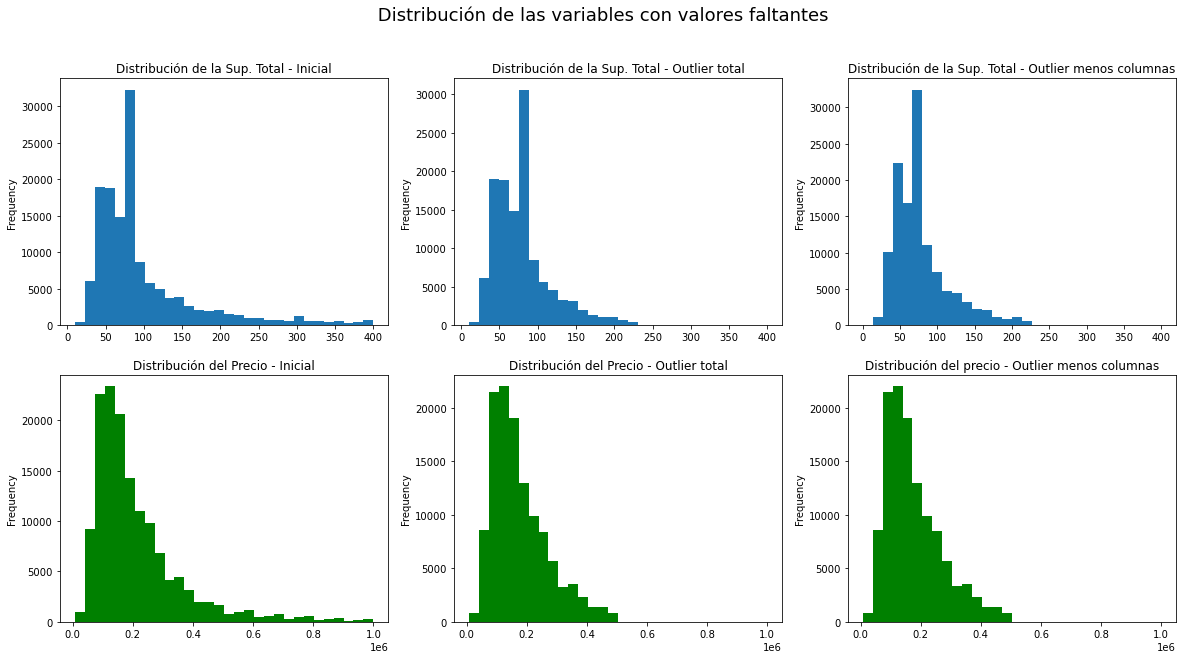

In [29]:
# Graficar las variables precio, superficie total y cubierta para las dos oportunidades de eliminación de outliers y el dataset original:


# Graficamos las distribuciones

f, axes = plt.subplots(1, 2 ,figsize=(20,10))
plt.suptitle (" Distribución de las variables con valores faltantes", fontsize = 18)

plt.subplot(2,3,1)
df.surface_total.plot.hist(bins = 30, range = (10, 400))
plt.title('Distribución de la Sup. Total - Inicial')


plt.subplot(2,3,2)
mascara_outliers.surface_total.plot.hist(bins = 30, range = (10, 400))
plt.title('Distribución de la Sup. Total - Outlier total')



plt.subplot(2,3,3)
mascara_outliers_2.surface_total.plot.hist(bins = 30, range = (0, 400))
plt.title('Distribución de la Sup. Total - Outlier menos columnas')




plt.subplot(2,3,4)
df.price.plot.hist(bins = 30, range = (7500, 1000000), color = "g")
plt.title('Distribución del Precio - Inicial')


plt.subplot(2,3,5)
mascara_outliers.price.plot.hist(bins = 30, range = (7500, 1000000), color = "g")
plt.title('Distribución del Precio - Outlier total')



plt.subplot(2,3,6)
mascara_outliers_2.price.plot.hist(bins = 30, range = (7500, 1000000), color = "g")
plt.title('Distribución del precio - Outlier menos columnas')



plt.show();




* Mediante el análisis realizado, se puede observar que filtrar los baños, superficie total y cubiertas no generar difecencias significativas en el análisis de la superficie total y cubierta, por lo que se puede proceder a trabajar con el Dataset eliminando outliers de todas las features.

In [30]:
# Eliminar Outliers máximos:
df_filtrado=df[(df.bathrooms <= 4) & (df.bedrooms<= 6) & (df.rooms<= 7)& (df.surface_total<= 183.5) & (df.surface_covered<= 156) & (df.price<= 5175000)]

df_filtrado.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,121781.000000,121781.000000,121781.000000,121781.000000,121781.000000,121781.000000,121781.000000,1.217810e+05
mean,-34.602376,-58.457272,2.731690,1.718840,1.400071,76.125603,66.236761,1.927259e+05
std,0.492484,0.506880,1.046944,0.931533,0.652050,32.199782,26.333326,1.630688e+05
min,-35.123742,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,7.500000e+03
25%,-34.621202,-58.486630,2.000000,1.000000,1.000000,51.000000,46.000000,1.070000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,76.000000,67.000000,1.550000e+05
75%,-34.579326,-58.412387,3.000000,2.000000,2.000000,88.000000,76.000000,2.320000e+05
max,85.051129,-57.847990,7.000000,6.000000,4.000000,183.000000,156.000000,5.000000e+06


Respecto a los valores mínimos, a través de la fórmula del rango Inercuartílico indica valors negativos, por lo que no deberían efectuarse eliminaciones. Conociendo las variables, se observan en la superficie total y cubierta valores mínimos que no serían correctos, que deberían ser eliminados.  

In [31]:
# Eliminar valores donde la superficie sea inferior a 15 mt2 y la sup. cubierta sea mayor a la superficie total:

df_filtrado=df_filtrado[(df_filtrado.surface_total>=15) | (df_filtrado.surface_covered>=15) ] 
df_filtrado = df_filtrado.loc[df_filtrado.surface_total >= df_filtrado.surface_covered]
df_filtrado.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,120369.000000,120369.000000,120369.00000,120369.000000,120369.000000,120369.000000,120369.000000,1.203690e+05
mean,-34.602308,-58.457230,2.73268,1.719022,1.402454,76.362020,66.183253,1.933960e+05
std,0.495270,0.509626,1.04671,0.932203,0.653731,32.200649,26.279811,1.636733e+05
min,-35.123742,-180.000000,1.00000,0.000000,1.000000,15.000000,1.000000,7.500000e+03
25%,-34.621131,-58.486305,2.00000,1.000000,1.000000,52.000000,46.000000,1.079480e+05
50%,-34.600943,-58.443262,3.00000,2.000000,1.000000,77.000000,67.000000,1.550000e+05
75%,-34.579326,-58.412461,3.00000,2.000000,2.000000,89.000000,75.000000,2.345000e+05
max,85.051129,-57.847990,7.00000,6.000000,4.000000,183.000000,156.000000,5.000000e+06


### Comprender el comportamiento de cada una de las variables:
Comprender el comportamiento de las variables a través de histogramas o gráficos de barra permite entender la información contenida en el dataset y cuentan la historia de los datos.

Text(0, 0.5, 'Frecuencia')

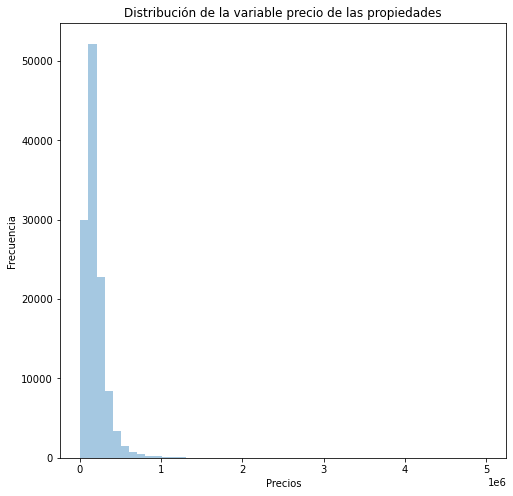

In [32]:
# Distribución de la variable precio:


plt.figure(figsize = (8,8))
sns.distplot(df_filtrado ['price'], kde = False)

plt.title("Distribución de la variable precio de las propiedades")
plt.xlabel("Precios")
plt.ylabel("Frecuencia")
#plt.xlim(0, 1000000)
#plt.ylim (0, 8000);

* Los precios de las propiedades se concentran en el rango inferior a los USD 200.000. Se observan valores  con baja frecuencia a partir de los USD 800.000, incluso superando el rango de un millón, pero que no fueron incluidos en la gráfica para no distorcionar la distribución.

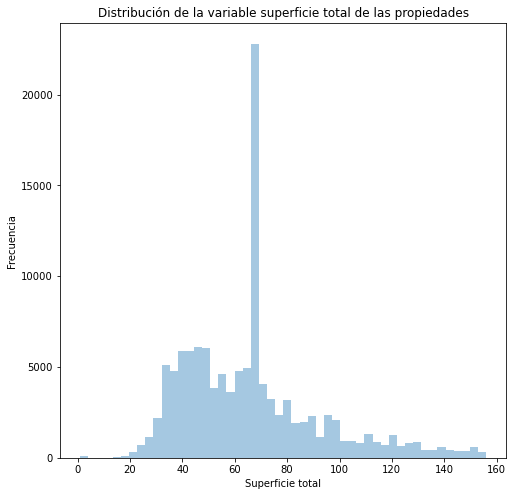

In [33]:
# Distribución de la variable Superficie total:

plt.figure(figsize = (8,8))
sns.distplot(df_filtrado['surface_covered'],  kde = False)

plt.title("Distribución de la variable superficie total de las propiedades")
plt.xlabel("Superficie total")
plt.ylabel("Frecuencia");

La superficie de las propiedades se encuentra concentrada entre los 45 y 150 mt2. Se presentan valores extremos superiores que deberán ser analizados.

### Análisis detallado de variables categóricas
Así como de las variables continuas los histogramas nos cuentan su distribución, de las variables categóricas es necesario conocer los tipos de categorías que se presentan en cada variable y su frecuencia de repetición. 

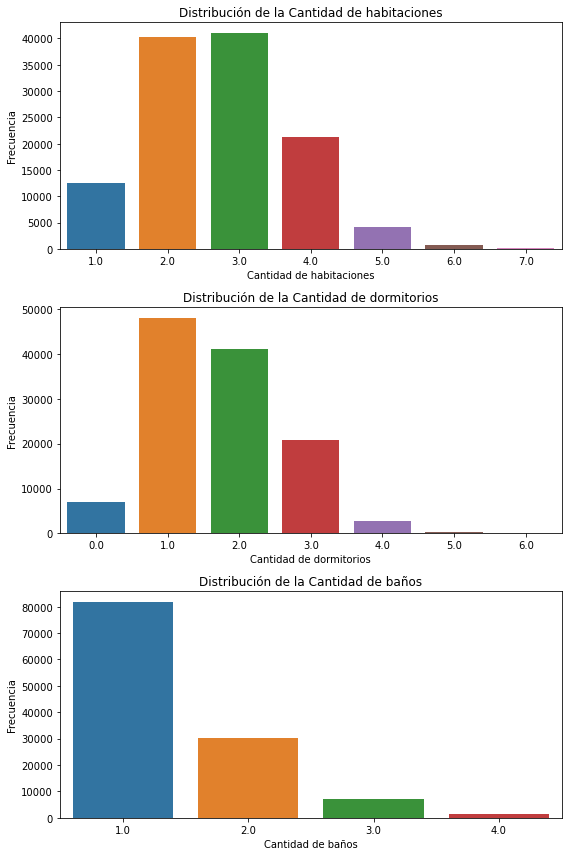

In [34]:
# Distribución de las variables: Cantidad de habitaciones, dormitorios y baños:
# hacer el gráfico inicial
plt.figure(figsize = (8,12))


#hacer el sub gráfico
plt.subplot(3,1,1)  
sns.countplot(data = df_filtrado, x = "rooms");
plt.title("Distribución de la Cantidad de habitaciones")
plt.xlabel("Cantidad de habitaciones")
plt.ylabel("Frecuencia")
#plt.xticks(rotation=90)
#plt.xlim(0, 10)


plt.subplot(3,1,2)
#plt.figure(figsize=(25,6))
sns.countplot(data = df_filtrado, x = "bedrooms");
plt.title("Distribución de la Cantidad de dormitorios")
plt.xlabel("Cantidad de dormitorios")
plt.ylabel("Frecuencia")
#plt.xlim(0, 10)


plt.subplot(3,1,3)
#plt.figure(figsize=(25,6))
sns.countplot(data = df_filtrado, x = "bathrooms");
plt.title("Distribución de la Cantidad de baños")
plt.xlabel("Cantidad de baños")
plt.ylabel("Frecuencia")
#plt.xlim(0, 10)


#plt.xticks(rotation=90) # girar los títulos de los ejes 90 grados


plt.tight_layout()
plt.show()


* La mayoría de las propiedades presentan 3 habitaciones, un dormitorio y un baño.

In [35]:
# Analizar la Cantidad de tipos de propiedad que hay publicados:
print ("La cantidad de tipos de propiedad publicados son: " , df_filtrado["property_type"].nunique()) 

La cantidad de tipos de propiedad publicados son:  10


In [36]:
# Tipos de Propiedad publicados

print ("Los tipos de propiedad publicados son: ", df_filtrado.property_type.unique())

Los tipos de propiedad publicados son:  ['PH' 'Departamento' 'Casa' 'Oficina' 'Lote' 'Otro' 'Cochera'
 'Local comercial' 'Casa de campo' 'Depósito']


In [37]:
#Instancias (frecuencia) por cada tipo de propiedad
df_filtrado["property_type"].value_counts()

Departamento       99041
PH                 11554
Casa                7433
Lote                 653
Oficina              609
Local comercial      311
Cochera              258
Depósito             255
Otro                 191
Casa de campo         64
Name: property_type, dtype: int64

In [38]:
# Porcentaje de cada tipo de propiedad:
print (porcentajes (df_filtrado, "property_type"))

Departamento       0.822812
PH                 0.095988
Casa               0.061752
Lote               0.005425
Oficina            0.005059
Local comercial    0.002584
Cochera            0.002143
Depósito           0.002118
Otro               0.001587
Casa de campo      0.000532
Name: property_type, dtype: float64


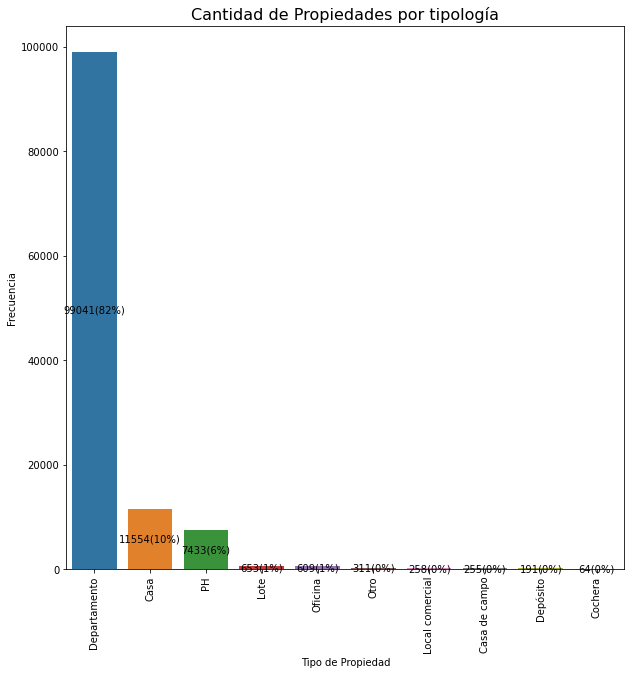

In [39]:

# Graficar la frecuencia de propiedades por tipología

figure, barras = plt.subplots(figsize=(10, 10))
sns.barplot(x= df["property_type"].value_counts().index, y = df_filtrado["property_type"].value_counts(), ax = barras)
barras.set_xlabel("Tipo de Propiedad")
barras.set_ylabel('Frecuencia')
barras.set_title('Cantidad de Propiedades por tipología', fontsize = 16)
plt.xticks(rotation=90) 

for patch in barras.patches:
    label_x = patch.get_x() + patch.get_width()/2  # find midpoint of rectangle
    label_y = patch.get_y() + patch.get_height()/2
    barras.text(label_x, label_y,
                #left - freq below - rel freq wrt population as a percentage
               str(int(patch.get_height())) + '(' +
               '{:.0%}'.format(patch.get_height()/len(df_filtrado.property_type))+')',
               horizontalalignment='center', verticalalignment='center')

La mayor cantidad de propiedades son Departamentos, representando un 73% de los casos, seguido de las casas y los PH con un valor del 14,67% y 9,7% respectivamente. El resto de los valores no alcanza el 1%.

In [40]:
# Analizar la Cantidad Regiones con datos publicados:
print ("La cantidad de tipos de propiedad publicados son: " , df_filtrado["property_type"].nunique()) 



La cantidad de tipos de propiedad publicados son:  10


In [41]:
# Clasificación de las Regiones con publicaciones:

print ("Las Zonas geográficas con Publicaciones son: ", df_filtrado.l2.unique())

Las Zonas geográficas con Publicaciones son:  ['Capital Federal' 'Bs.As. G.B.A. Zona Sur' 'Bs.As. G.B.A. Zona Norte'
 'Bs.As. G.B.A. Zona Oeste']


In [42]:
#Instancias (frecuencia) por región
print (df_filtrado["l2"].value_counts())

Capital Federal             81869
Bs.As. G.B.A. Zona Norte    17570
Bs.As. G.B.A. Zona Sur      12030
Bs.As. G.B.A. Zona Oeste     8900
Name: l2, dtype: int64


In [43]:
# Porcentaje de cada región:
print (porcentajes (df_filtrado, "l2"))

Capital Federal             0.680150
Bs.As. G.B.A. Zona Norte    0.145968
Bs.As. G.B.A. Zona Sur      0.099943
Bs.As. G.B.A. Zona Oeste    0.073939
Name: l2, dtype: float64


In [44]:
# Región con más propiedades publicadas:
print ("La región con más propiedades publicadas es " , df_filtrado["l2"].max() )

La región con más propiedades publicadas es  Capital Federal


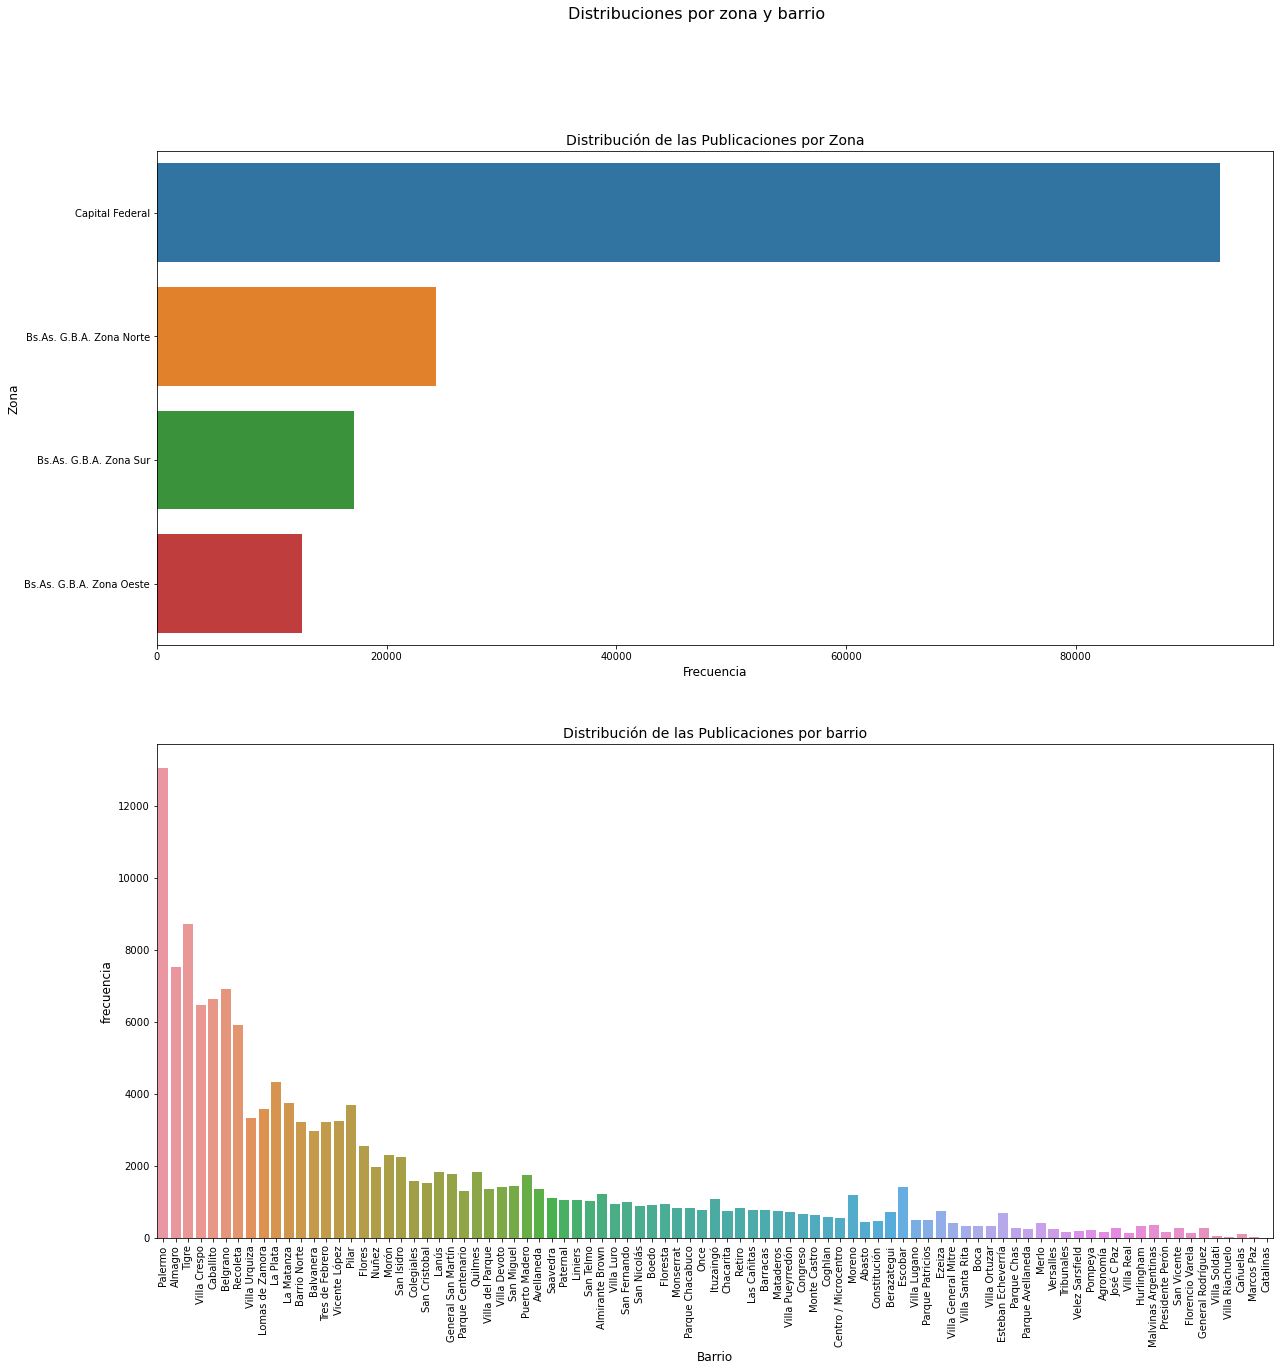

In [45]:
#Distribución de las publicaciones por región

f, axes = plt.subplots(2, 1 ,figsize=(20,20))
sns.countplot(data = df, y = "l2", ax=axes[0],order = df_filtrado['l2'].value_counts().index )
sns.countplot(data = df, x = "l3", ax=axes[1],order = df_filtrado['l3'].value_counts().index )
plt.xticks(rotation = 90)
plt.suptitle ("Distribuciones por zona y barrio", fontsize= 16)
axes[0].set_title('Distribución de las Publicaciones por Zona', fontsize=14)
axes[1].set_title('Distribución de las Publicaciones por barrio', fontsize=14)
axes[0].set_ylabel('Zona', fontsize=12)
axes[0].set_xlabel('Frecuencia', fontsize=12)
axes[1].set_xlabel('Barrio', fontsize=12)
axes[1].set_ylabel('frecuencia', fontsize=12)
plt.show();

*  Más del 60% de las publicaciones se encuentran en Capital Federal, donde Zona Oeste es la que presenta menor presentación, con menos valores del 8%.
* A nivel de publicaciones por barrio, se observa también una diferencia significativa en la cantidad de propiedades presentes en Palermo respecto al resto. Luego, con una frecuencia cercanamente similar, se encuentran eel grupo de barrios de Tigre, Almagro, Belgrano y Caballito, los cuales no pertenecen a la misma zona geográfica l2.

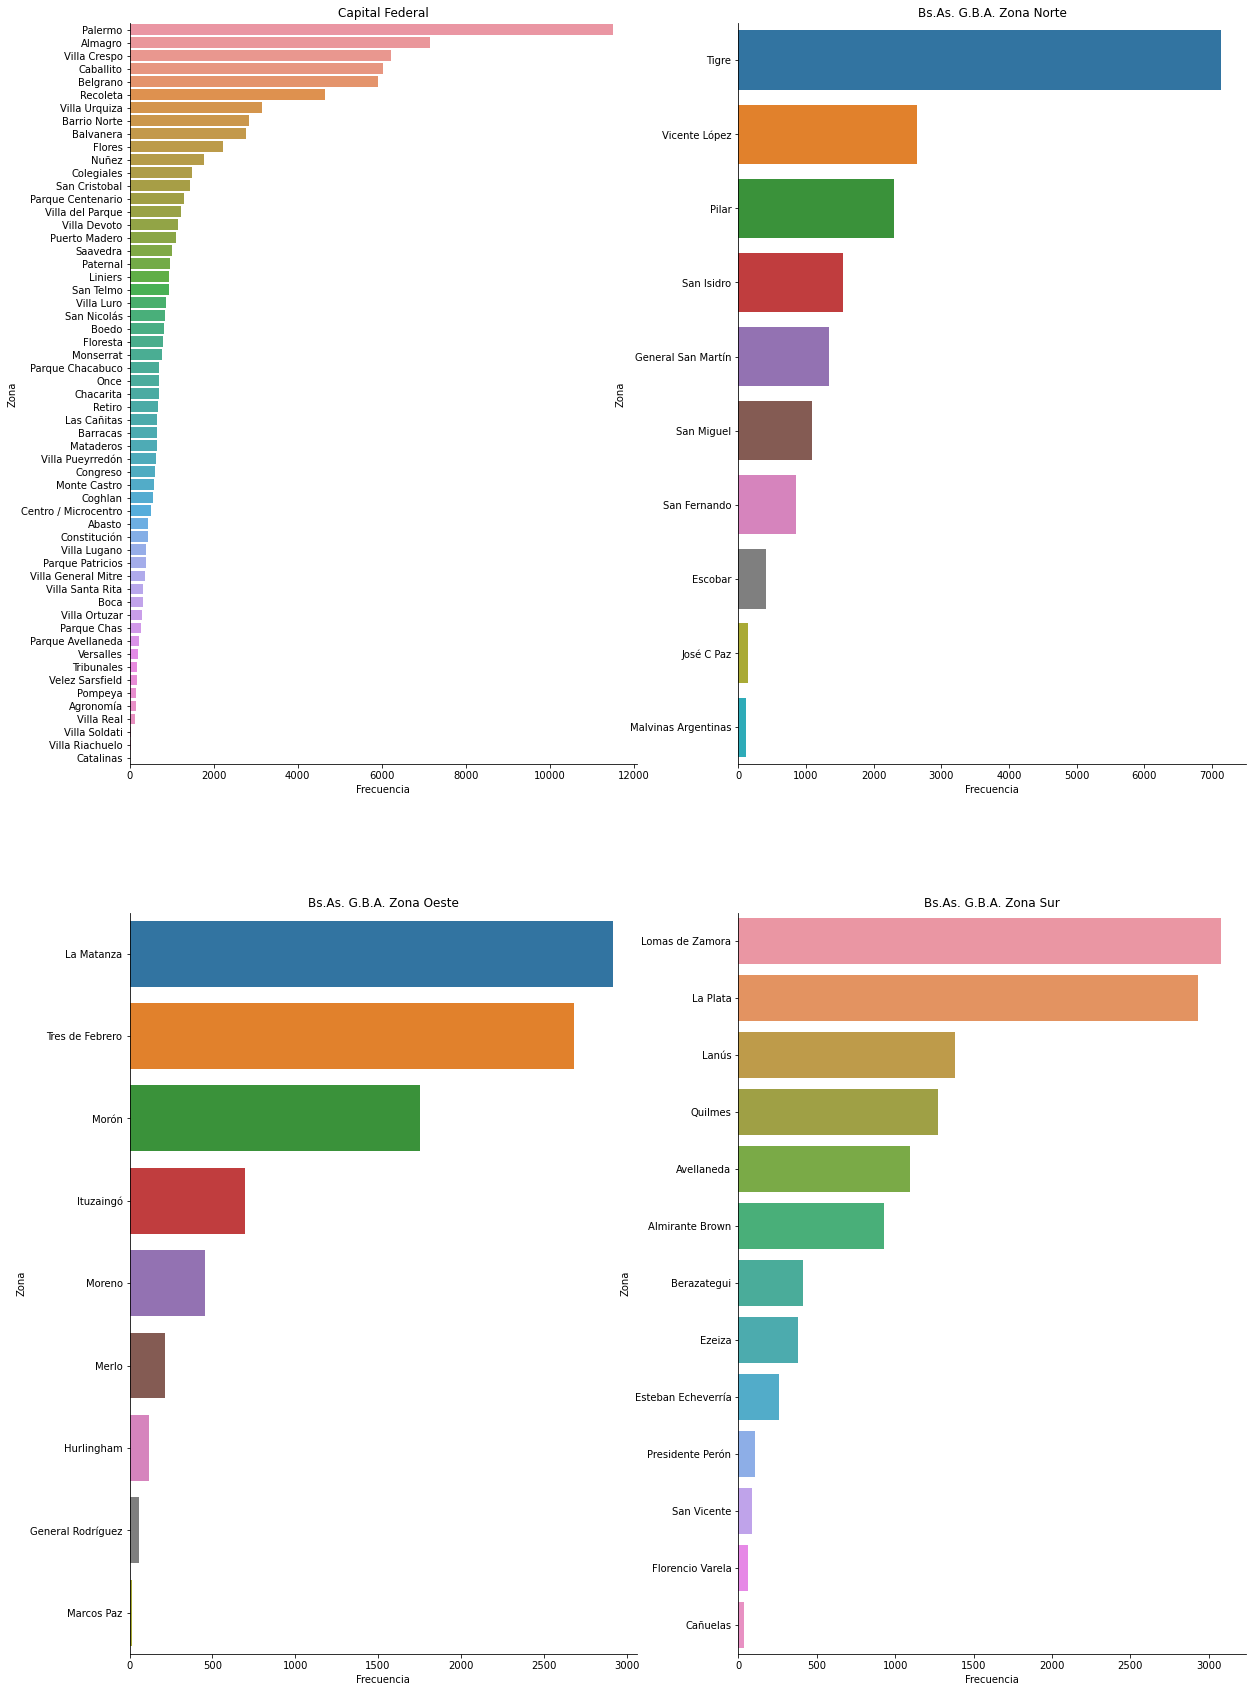

In [46]:
# Graficar la Frecuencia de las pubicaciones por barrio, segmentando por zona geográfica l2.
# Separar las zonas geográficas en distintos datasets
capital=df_filtrado.loc[df.loc[:, 'l2'] == 'Capital Federal']
bs_norte=df_filtrado.loc[df.loc[:, 'l2'] == 'Bs.As. G.B.A. Zona Norte']
bs_oeste=df_filtrado.loc[df.loc[:, 'l2'] == 'Bs.As. G.B.A. Zona Oeste']
bs_sur=df_filtrado.loc[df.loc[:, 'l2'] == 'Bs.As. G.B.A. Zona Sur']

# Graficar
f, axes = plt.subplots(2, 2 ,figsize=(20,30))
sns.countplot(data = capital, y = "l3", ax=axes[0,0],order = capital['l3'].value_counts().index )
sns.countplot(data = bs_norte, y = "l3", ax=axes[0,1],order = bs_norte['l3'].value_counts().index )
sns.countplot(data = bs_oeste, y = "l3", ax=axes[1,0],order = bs_oeste['l3'].value_counts().index )
sns.countplot(data = bs_sur, y = "l3", ax=axes[1,1],order = bs_sur['l3'].value_counts().index )

axes[0,0].set_title('Capital Federal')
axes[0,1].set_title('Bs.As. G.B.A. Zona Norte')
axes[1,0].set_title('Bs.As. G.B.A. Zona Oeste')
axes[1,1].set_title('Bs.As. G.B.A. Zona Sur')

axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)

axes[0,0].set_xlabel('Frecuencia')
axes[0,1].set_xlabel('Frecuencia')
axes[1,0].set_xlabel('Frecuencia')
axes[1,1].set_xlabel('Frecuencia')

axes[0,0].set_ylabel('Zona')
axes[0,1].set_ylabel('Zona')
axes[1,0].set_ylabel('Zona')
axes[1,1].set_ylabel('Zona')

plt.show()

In [47]:
print ("Porcentajes por barrio: ")
print (porcentajes (df_filtrado,"l3"))

Porcentajes por barrio: 
Palermo            0.095440
Almagro            0.059301
Tigre              0.059301
Villa Crespo       0.051600
Caballito          0.050079
                     ...   
Villa Soldati      0.000316
Villa Riachuelo    0.000282
Cañuelas           0.000282
Marcos Paz         0.000116
Catalinas          0.000042
Name: l3, Length: 89, dtype: float64


Efectuando la segmentación de la cantidad de publicaciones por barrio teniendo en cuenta la zona geográfica, se puede observar que en el caso de Capital Federal, la inmobiliaria presenta publicaciones en gran cantidad de barrios comparado con el resto de las zonas geográficas, donde la representatividad del barrio de Palermo es notablemente superior a resto.
En Zona Norte, la cantidad de barrios con publicación se encuentran más atomizados, pero el barrio de Tigre presenta una amplia diferencia comparado con el resto.
En Zona Oeste y Sur este fenómeno no se presenta tan marcado.

Estas observaciones son relevantes si el comportamiento de los precios u otras de las features de los barrios con mayor frecuencia, difieren de manera significativa con el resto de los barrios. 

## Análisis de los precios por zona y Tipo de propiedad
Para llevar a cabo las predicciones, es importante tener en cuenta la distribución de la variable predictora "y" (en este caso, el precio) como la distribución de las features que se utilizarán para predecir.
Esto indica que el dataset esté balanceado.
Es por ello, que es necesario comprender la distribución de las variables para gestionar correctamente el dataset previo a entrenar el algoritmo de predicción.

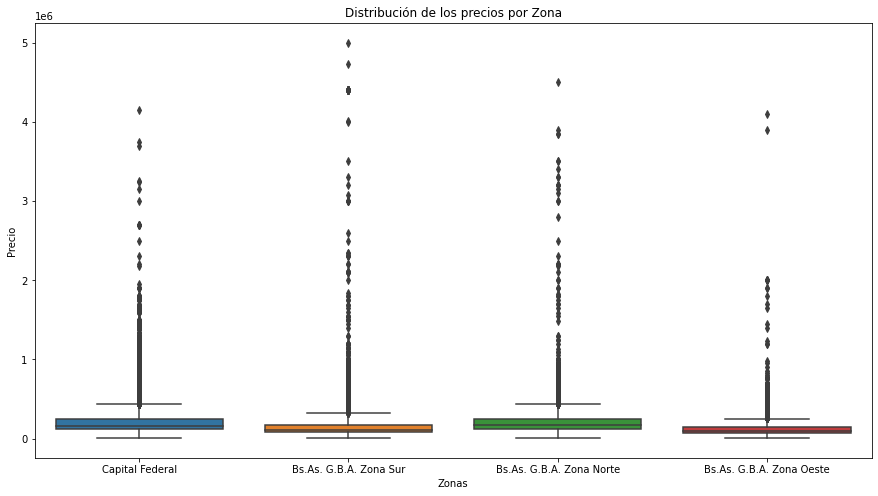

In [48]:
# Efectuar Bloxplots de la distribución de precios por zona:
plt.figure(figsize = (15,8))

sns.boxplot(data = df_filtrado, y = "price", x = "l2" )
plt.title("Distribución de los precios por Zona")
plt.xlabel ("Zonas")
plt.ylabel("Precio")
plt.show()

* Se puede observar el Zona Norte y Capital Federal tienen una distribución similar en rango de precios y media, siendo superiores a Zona Sur y Oeste. Zona Oeste es la que presenta precios más bajos y una distribución más concentrada para el 75% de sus datos, pero con mayor dispersión de los datos fuera de este rango.

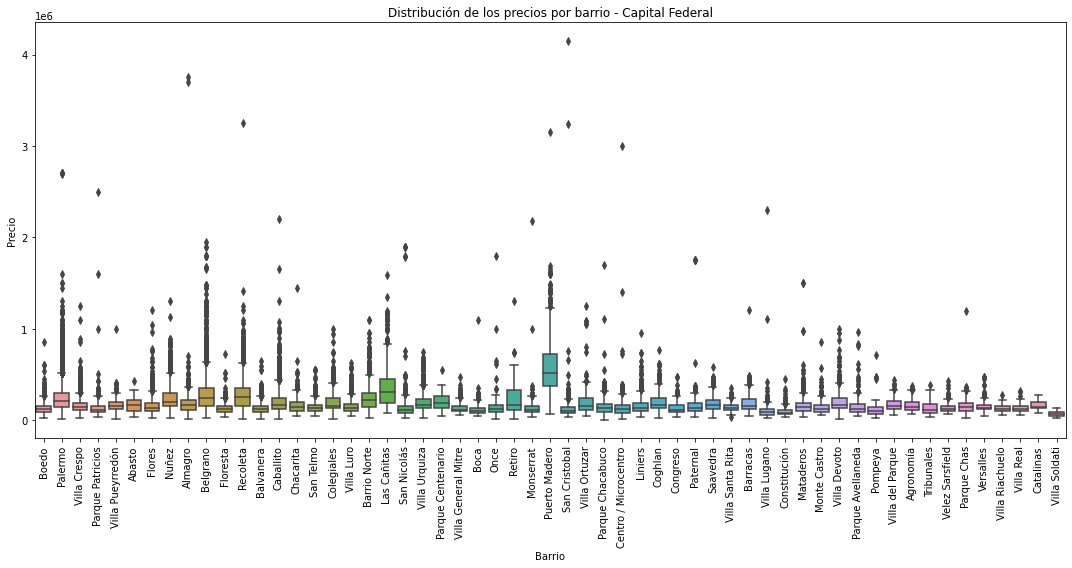

In [49]:
# Analizar la distribución de los precios por barrio:
# Graficar nuevamente el Boxplot de la distribución de los precios por tipo de propiedad
plt.figure(figsize = (15,8))
sns.boxplot(data = capital, x = 'l3', y = "price")
plt.title("Distribución de los precios por barrio - Capital Federal")
plt.xlabel("Barrio")
plt.ylabel("Precio")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* Los precios de las propiedades en Palermo, clasificando por barrio presentan una dispersión significativa, tanto individualmente como por barrio.
* Es importante destacar además, la gran cantidad de barrios que presentan publicaciones en capital Federal.

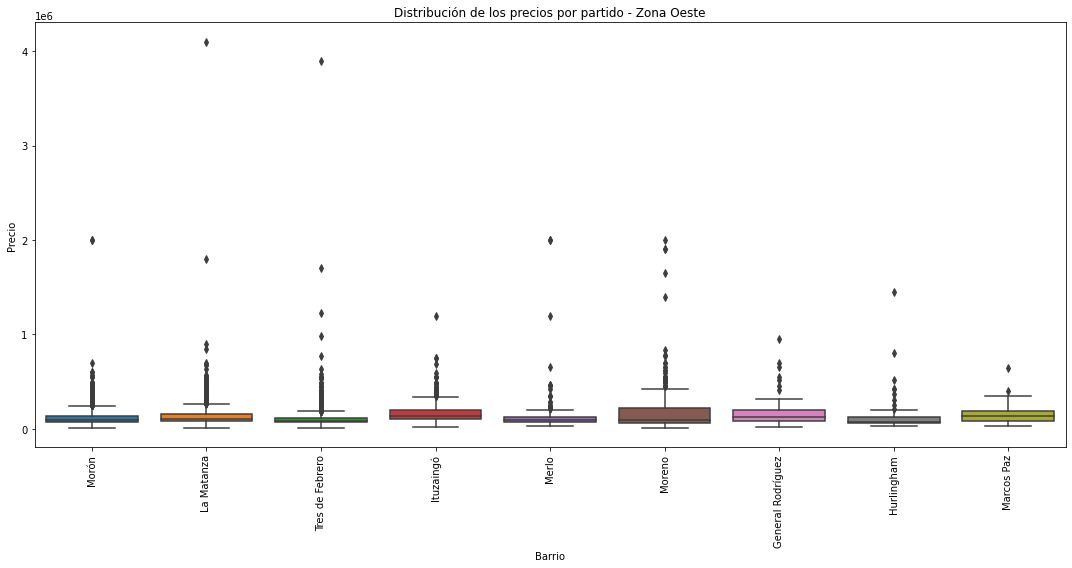

In [50]:
# Graficar nuevamente el Boxplot de la distribución de los precios por tipo de propiedad
plt.figure(figsize = (15,8))
sns.boxplot(data = bs_oeste, x = 'l3', y = "price")
plt.title("Distribución de los precios por partido - Zona Oeste")
plt.xlabel("Barrio")
plt.ylabel("Precio")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* En Zona Oeste, los precios mínimos de las propiedades son muy similares para todos los partidos, y la distribución de los datos se encuentra muy concentrada. En todos los casos se observa la presencia de outliers.

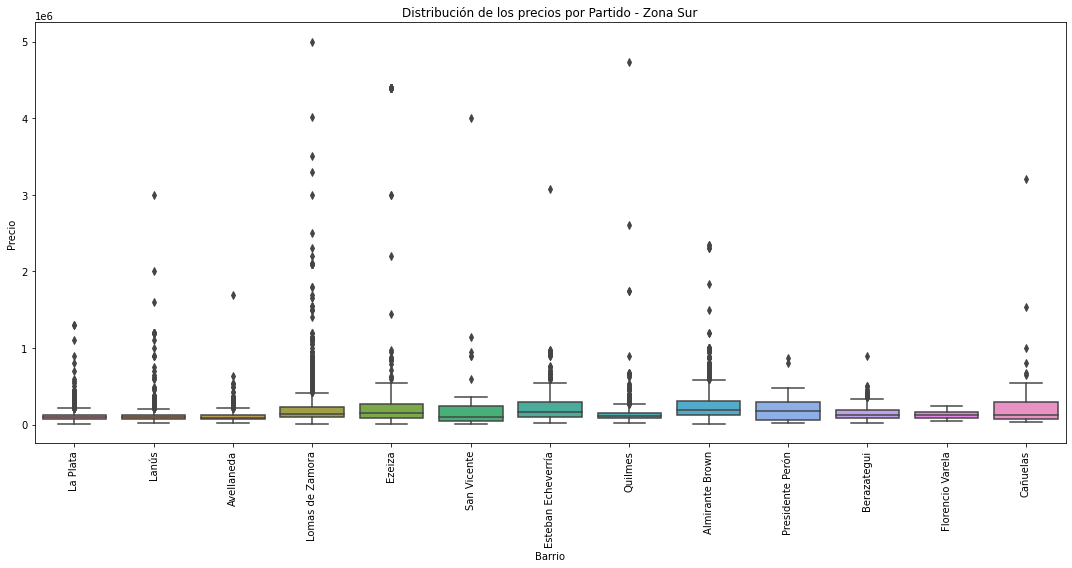

In [51]:
# Graficar nuevamente el Boxplot de la distribución de los precios por tipo de propiedad
plt.figure(figsize = (15,8))
sns.boxplot(data = bs_sur, x = 'l3', y = "price")
plt.title("Distribución de los precios por Partido - Zona Sur")
plt.xlabel("Barrio")
plt.ylabel("Precio")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* Zona Sur presenta una distribución de sus precios por partido muy similar para muchos de ellos, como son: La Plata, Lanús, Avellaneda, Quilmes, Florencio Varela. A su vez, presentan menor dispersión para el 75% de los datos.

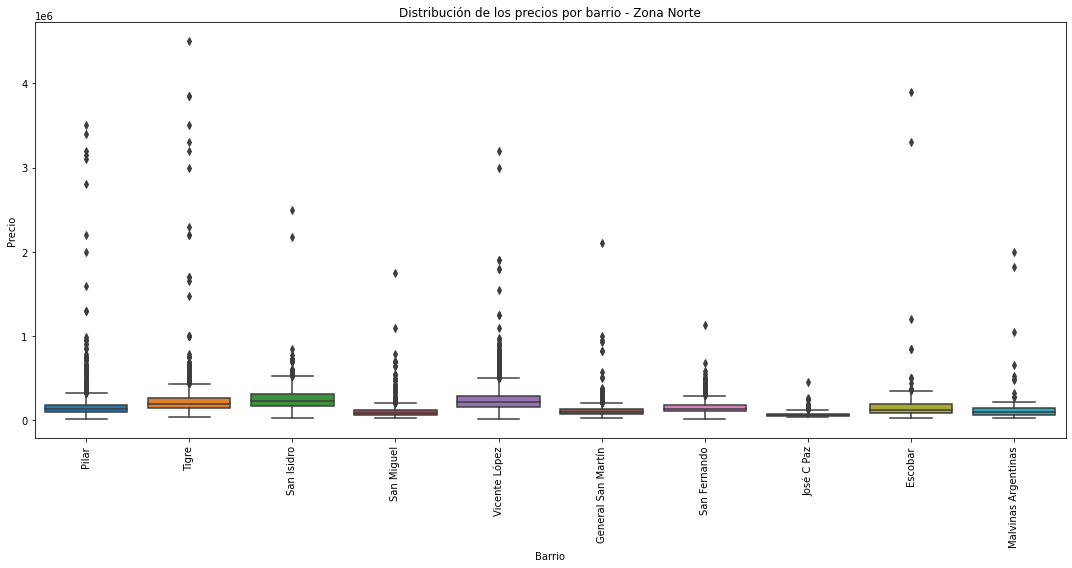

In [52]:
# Analizar la distribución de los precios por zona y barrio:
# Graficar nuevamente el Boxplot de la distribución de los precios por tipo de propiedad
plt.figure(figsize = (15,8))
sns.boxplot(data = bs_norte, x = 'l3', y = "price")
plt.title("Distribución de los precios por barrio - Zona Norte")
plt.xlabel("Barrio")
plt.ylabel("Precio")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* En Zona Norte, la inmobiliaria presenta publicaciones en menor cantidad de barrios, aunque los precios tampoco se encuentran atomizados entre ellos. Si se observan barrios con distribuciones con menor dispersión alrededor del 75% de los datos, como ser el caso de Pilar, San Isidro y Vicente López.

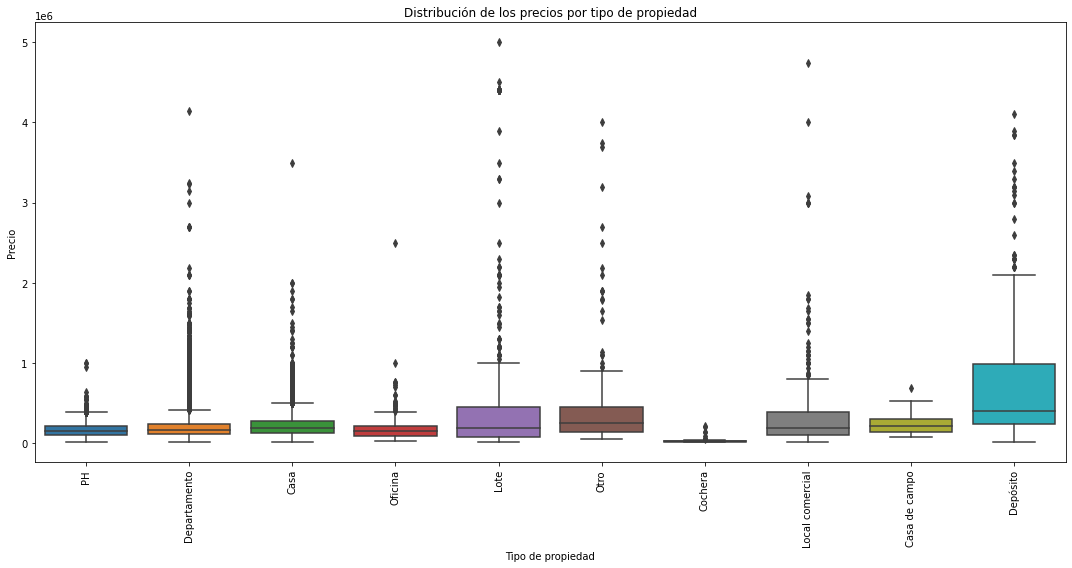

In [53]:
# Graficar nuevamente el Boxplot de la distribución de los precios por tipo de propiedad
plt.figure(figsize = (15,8))
sns.boxplot(data = df_filtrado, x = 'property_type', y = "price")
plt.title("Distribución de los precios por tipo de propiedad")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Precio")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* La distribución de los precios por tipo de propiedad, para los casos de casas, departamentos y oficina a grandes razgos presentan una distribución similar, con un grado de asimetría similar. Las oficinas, varían en un rango de precio levemente interior para el 75% de los datos pero presenta mayor dispersión.

### Análisis de correlación de las variables 
Analizar la correlación entre las variables tiene como indicar si existe relación entre dos variables, la naturaleza de dicha relación, y su fuerza.
* Correlación positiva: ambas se comportan en misma dirección ante cambios en una de ella.
* Correlación negativa: Ante incrementos en una de las variables, la otra decrece.
Existen distintos tipos de análisis de correlación, en este caso se efectuará el análisis de correlación lineal entre las variables del dataset.


In [54]:
#Análisis de correlación entre variables
df_corr= df_filtrado.corr()
df_corr

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
lat,1.000000,-0.985039,-0.008991,0.011629,0.013640,0.005713,0.005048,0.012294
lon,-0.985039,1.000000,0.008226,-0.000827,-0.007781,-0.008678,0.000700,0.004907
rooms,-0.008991,0.008226,1.000000,0.864344,0.516268,0.617650,0.659427,0.341034
bedrooms,0.011629,-0.000827,0.864344,1.000000,0.473194,0.571529,0.614641,0.304769
bathrooms,0.013640,-0.007781,0.516268,0.473194,1.000000,0.510230,0.554834,0.469619
surface_total,0.005713,-0.008678,0.617650,0.571529,0.510230,1.000000,0.897964,0.430275
surface_covered,0.005048,0.000700,0.659427,0.614641,0.554834,0.897964,1.000000,0.472327
price,0.012294,0.004907,0.341034,0.304769,0.469619,0.430275,0.472327,1.000000


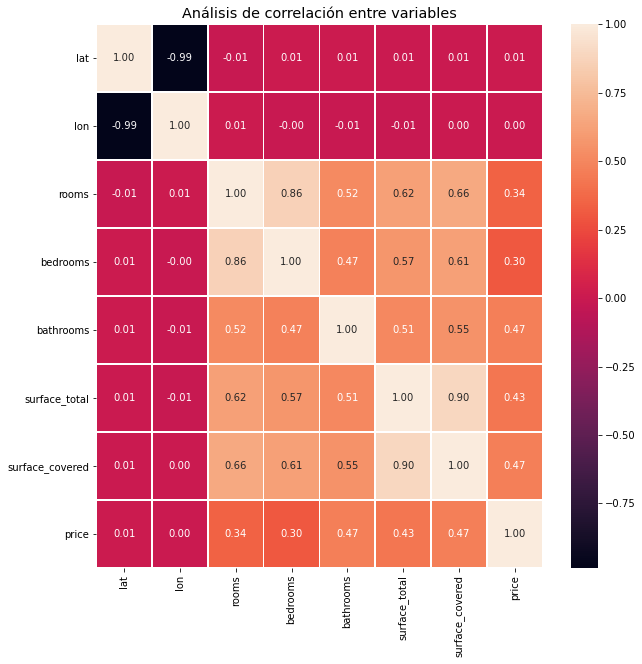

In [55]:
#Gráfico de correlaciones
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_filtrado.corr(), annot=True, linewidths=0.5, fmt='.2f',ax=ax)
plt.title("Análisis de correlación entre variables", size = "x-large")

ax.set_ylim(8, 0);

Se puede observar que todas la variables presentan correlación positiva con la variable precio, siendo en todos los casos superior a 0.5.
La variable superficie cubierta, es la que presenta mayor correlación, alcanzando un valor de 0.74.
La variable superficie cubierta y superficie total se encuentran ampliamente correlacionadas entre ellas.
Las variables cantidad de baños y cantidad de habitaciones, son las dos variables que presentan mayor correlación con la variable precio, luego de la superficie cubierta.
Las variables cantidad de habitaciones y cantidad de dormitorios se encuentran altamente relacionadas entre sí.

# Conclusiones del análisis Exploratorio de datos
* El dataset presenta información respecto al precio de venta de propiedades para una inmobiliaria que presenta publicaciones en Capital Federal, Zona Norte, Zona Sur y Zona Oeste, donde el 63% de las publicaciones son de Capital Federal, el 16,5% de Zona Norte, 11,7% Zona Oeste y 8,6% Zona Sur.
* A nivel de barrios, el barrio de Palermo representa el 8,9% del Dataset total, donde se presentan 89 barrios, seguido de Tigre y Almagro con un 59% y 51% respectivamente.
* Se presentan al menos 10 tipos de propiedades, donde los más relevantes son: Departamentos con el 73%, Casas el 14% y PHs el 9%.
* Todas las variables con correlación significativa su relación es positiva, donde la superficie cubierta, total y cantidad de baños son las más relevantes.
* Debido a que la mayoría de los datos se refieren Capital Federal, se considera que para optimizar las predicciones es necesario efectuarlas separarlas por Zona Geográfica.
Se llevará a cabo un análisis exploratorio de Capital Federal por separado para determinar si a su vez es necesario efectuar nuevas particiones de los datos, ya que existen 3 barrios muy respresentativos respecto a resto y si la variable precio u otras características presentan un comportamiento distinto al resto de los barrios, como también la concentración de los tipos de propiedad en Departamentos, lo que podrían afectar la capacidad de predicción del algoritmo.


## Análisis exploratorio de Capital Federal

In [57]:
# Se parte del dataset original, solo con imputación de valores faltanes para efectuar un nuevo análisis de Outliers
df_capital = df[df.l2.isin(["Capital Federal"])]
df_capital.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
5,2019-10-17,2019-11-01,2019-10-17,-34.593779,-58.441239,Argentina,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta


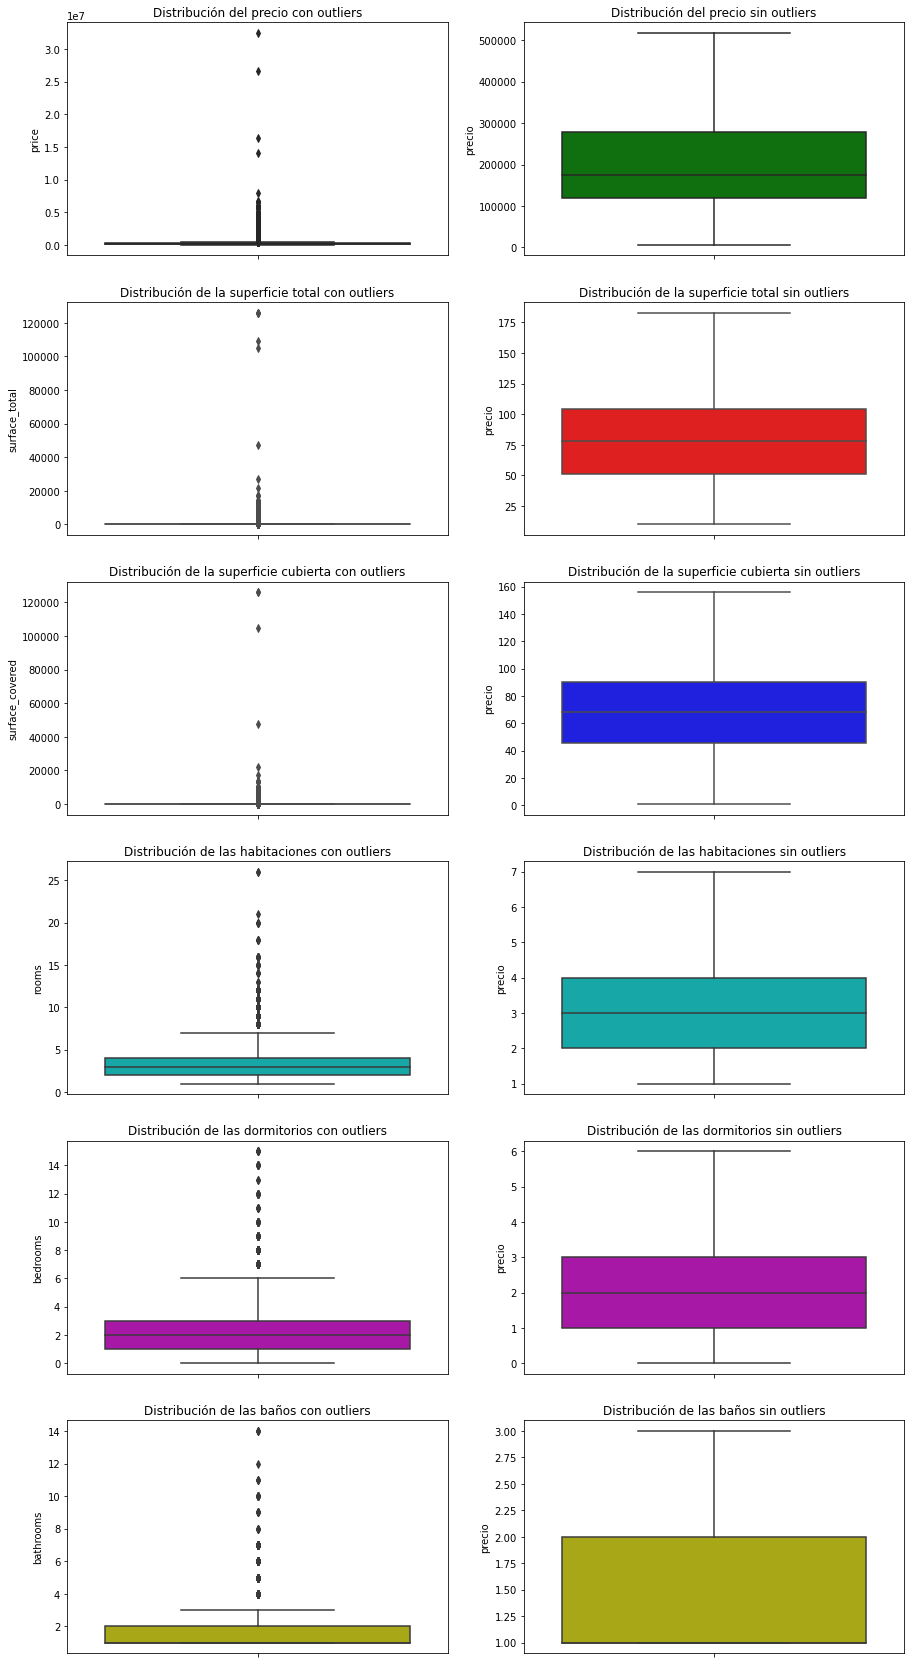

In [58]:
# Graficar las variables con y sin outliers para la comparación


plt.figure(figsize = (15,30))

plt.subplot(6,2,1) #
sns.boxplot(data = df_capital, y = "price", color = "g")
plt.title("Distribución del precio con outliers")


plt.subplot(6,2,2) #
sns.boxplot(data = df_capital, y = "price", color = "g", showfliers = False)
plt.title("Distribución del precio sin outliers")
plt.ylabel("precio")



plt.subplot(6,2,3) #
sns.boxplot(data = df_capital, y = "surface_total", color = "r")
plt.title("Distribución de la superficie total con outliers")


plt.subplot(6,2,4) #
sns.boxplot(data = df_capital, y = "surface_total", color = "r", showfliers = False)
plt.title("Distribución de la superficie total sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,5) #
sns.boxplot(data = df_capital, y = "surface_covered", color = "b")
plt.title("Distribución de la superficie cubierta con outliers")


plt.subplot(6,2,6) #
sns.boxplot(data = df_capital, y = "surface_covered", color = "b", showfliers = False)
plt.title("Distribución de la superficie cubierta sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,7) #
sns.boxplot(data = df_capital, y = "rooms", color = "c")
plt.title("Distribución de las habitaciones con outliers")


plt.subplot(6,2,8) #
sns.boxplot(data = df_capital, y = "rooms", color = "c", showfliers = False)
plt.title("Distribución de las habitaciones sin outliers")
plt.ylabel("precio")

plt.subplot(6,2,9) #
sns.boxplot(data = df_capital, y = "bedrooms", color = "m")
plt.title("Distribución de las dormitorios con outliers")


plt.subplot(6,2,10) #
sns.boxplot(data = df_capital, y = "bedrooms", color = "m", showfliers = False)
plt.title("Distribución de las dormitorios sin outliers")
plt.ylabel("precio")


plt.subplot(6,2,11) #
sns.boxplot(data = df_capital, y = "bathrooms", color = "y")
plt.title("Distribución de las baños con outliers")


plt.subplot(6,2,12) #
sns.boxplot(data = df_capital, y = "bathrooms", color = "y", showfliers = False)
plt.title("Distribución de las baños sin outliers")
plt.ylabel("precio");


In [59]:
# Analizar los rangos máximos y mínimos para que un registro sea considerado outlier:


print('Rango mínimo y máximo para Superficie total:',outlier_treatment(df_capital.surface_total), sep = '\n')
print('Rango mínimo y máximo para Superficie cubierta:',outlier_treatment(df_capital.surface_covered), sep = '\n')
print('Rango mínimo y máximo para precio:',outlier_treatment(df_capital.price), sep = '\n')
print('Rango mínimo y máximo para cantidad de habitaciones:',outlier_treatment(df_capital.rooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de dormitorios:',outlier_treatment(df_capital.bedrooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de baños:',outlier_treatment(df_capital.bathrooms), sep = '\n')

Rango mínimo y máximo para Superficie total:
(-28.5, 183.5)
Rango mínimo y máximo para Superficie cubierta:
(-20.0, 156.0)
Rango mínimo y máximo para precio:
(-118500.0, 517500.0)
Rango mínimo y máximo para cantidad de habitaciones:
(-1.0, 7.0)
Rango mínimo y máximo para cantidad de dormitorios:
(-2.0, 6.0)
Rango mínimo y máximo para cantidad de baños:
(-0.5, 3.5)


In [60]:
# Eliminar Outliers máximos:
df_capital=df_capital[(df_capital.bathrooms <= 4) & (df_capital.bedrooms<= 6) & (df_capital.rooms<= 7)& (df_capital.surface_total<= 183.5) & (df_capital.surface_covered<= 156) & (df_capital.price<= 5175000)]

df_capital.describe()


,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,82760.000000,82760.000000,82760.000000,82760.000000,82760.000000,82760.000000,82760.000000,8.276000e+04
mean,-34.599220,-58.436907,2.717061,1.771025,1.398079,74.243946,65.720988,2.017054e+05
std,0.023112,0.034907,1.037642,0.894628,0.651732,32.408075,27.738721,1.425193e+05
min,-34.696419,-58.530467,1.000000,0.000000,1.000000,10.000000,1.000000,7.500000e+03
25%,-34.612687,-58.457795,2.000000,1.000000,1.000000,49.000000,44.000000,1.165000e+05
50%,-34.600943,-58.436665,3.000000,2.000000,1.000000,71.000000,63.000000,1.650000e+05
75%,-34.585990,-58.413156,3.000000,2.000000,2.000000,88.000000,77.000000,2.420000e+05
max,-34.535818,-58.353930,7.000000,6.000000,4.000000,183.000000,156.000000,4.144561e+06


In [61]:
# Eliminar valores mínimos:
df_capital = df_capital[(df_capital.surface_total>=15) | (df_capital.surface_covered>=15) ] 
df_capital = df_capital.loc[df_capital.surface_total >= df_capital.surface_covered]
df_capital.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,8.186900e+04
mean,-34.599156,-58.436852,2.719845,1.772942,1.400872,74.483199,65.728322,2.024118e+05
std,0.023037,0.034827,1.037707,0.895436,0.653407,32.409008,27.746545,1.428603e+05
min,-34.696419,-58.530467,1.000000,0.000000,1.000000,15.000000,1.000000,7.500000e+03
25%,-34.612581,-58.457528,2.000000,1.000000,1.000000,50.000000,44.000000,1.171570e+05
50%,-34.600943,-58.436634,3.000000,2.000000,1.000000,71.000000,63.000000,1.650000e+05
75%,-34.585990,-58.413190,3.000000,2.000000,2.000000,88.000000,78.000000,2.440000e+05
max,-34.535818,-58.353930,7.000000,6.000000,4.000000,183.000000,156.000000,4.144561e+06


In [62]:
# Agregar la columna de precio por metro cuadrado:

df_capital["precio_mt2"] = df_capital ["price"] / df_capital["surface_covered"]
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


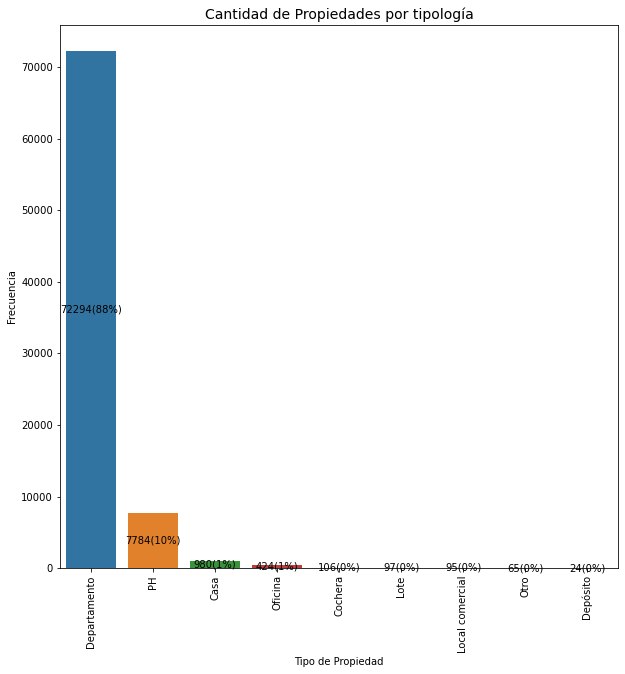

In [63]:
# Distribución de las publicaciones por tipología:

figure, barras = plt.subplots(figsize=(10, 10))
sns.barplot(x= df_capital["property_type"].value_counts().index, y = df_capital["property_type"].value_counts(), ax = barras)
barras.set_xlabel("Tipo de Propiedad")
barras.set_ylabel('Frecuencia')
barras.set_title('Cantidad de Propiedades por tipología', fontsize = 14)
plt.xticks(rotation=90) 

for patch in barras.patches:
    label_x = patch.get_x() + patch.get_width()/2  # find midpoint of rectangle
    label_y = patch.get_y() + patch.get_height()/2
    barras.text(label_x, label_y,
                #left - freq below - rel freq wrt population as a percentage
               str(int(patch.get_height())) + '(' +
               '{:.0%}'.format(patch.get_height()/len(df_capital.property_type))+')',
               horizontalalignment='center', verticalalignment='center');

* En Capital Federal, el 88% de los tipos de propiedad son Departamentos seguido por PHs que representan el 10%. El resto de los tipos de propiedad representan un valor de un 1% o inferior.

In [64]:
# Descripción estadística de las variables
df_capital.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,precio_mt2
count,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,81869.000000,8.186900e+04,81869.000000
mean,-34.599156,-58.436852,2.719845,1.772942,1.400872,74.483199,65.728322,2.024118e+05,3192.672052
std,0.023037,0.034827,1.037707,0.895436,0.653407,32.409008,27.746545,1.428603e+05,6601.913408
min,-34.696419,-58.530467,1.000000,0.000000,1.000000,15.000000,1.000000,7.500000e+03,176.470588
25%,-34.612581,-58.457528,2.000000,1.000000,1.000000,50.000000,44.000000,1.171570e+05,2305.263158
50%,-34.600943,-58.436634,3.000000,2.000000,1.000000,71.000000,63.000000,1.650000e+05,2844.117647
75%,-34.585990,-58.413190,3.000000,2.000000,2.000000,88.000000,78.000000,2.440000e+05,3529.411765
max,-34.535818,-58.353930,7.000000,6.000000,4.000000,183.000000,156.000000,4.144561e+06,980000.000000


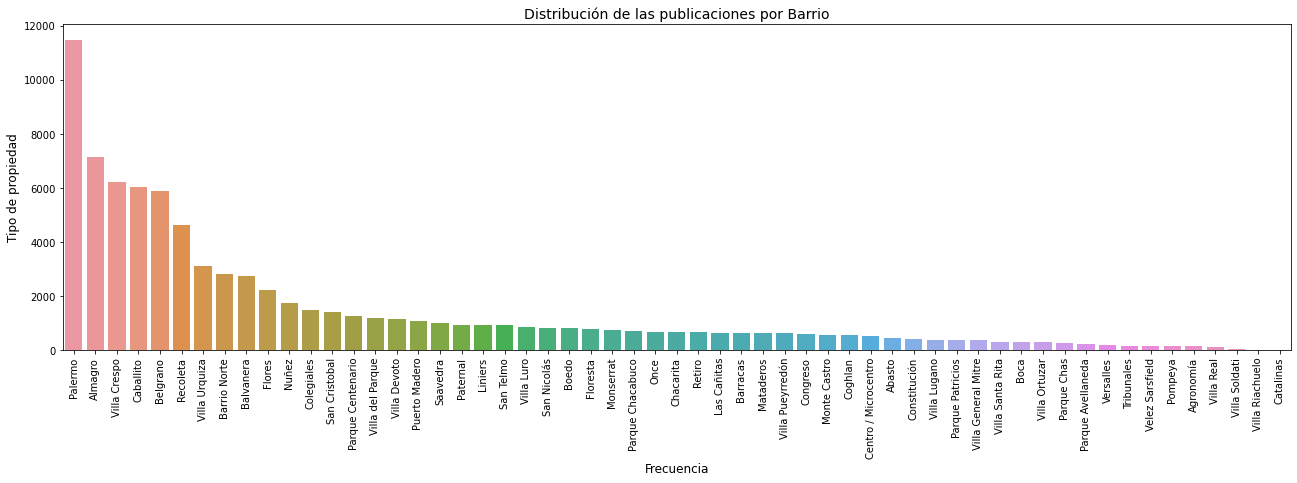

In [65]:
# Verficar la cantidad de publicaciones por tipo de barrio:

plt.figure(figsize = (22,6))
sns.countplot(data = df_capital, x = "l3", order = df_capital['l3'].value_counts().index )
plt.xticks(rotation = 90)
plt.title ("Distribución de las publicaciones por Barrio", fontsize= 14)

plt.ylabel('Tipo de propiedad', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

In [66]:
print ("Porcentajes por Barrio:")
print (porcentajes(df_capital, "l3"))

Porcentajes por Barrio:
Palermo                 0.140322
Almagro                 0.087188
Villa Crespo            0.075865
Caballito               0.073630
Belgrano                0.072152
Recoleta                0.056871
Villa Urquiza           0.038342
Barrio Norte            0.034714
Balvanera               0.033737
Flores                  0.027251
Nuñez                   0.021620
Colegiales              0.018114
San Cristobal           0.017565
Parque Centenario       0.015720
Villa del Parque        0.014853
Villa Devoto            0.014108
Puerto Madero           0.013375
Saavedra                0.012447
Paternal                0.011604
Liniers                 0.011531
San Telmo               0.011506
Villa Luro              0.010615
San Nicolás             0.010175
Boedo                   0.010004
Floresta                0.009601
Monserrat               0.009283
Parque Chacabuco        0.008550
Once                    0.008538
Chacarita               0.008428
Retiro             

* El 14% de las publicaciones de Capital Federal son del barrio de Palermo, seguido de Almagro (8,7%), Villa Crespo, Caballito y Belgrano (7%). El resto de las publicaciones presentan valores iguales o inferiores al 5%.

In [67]:
# Verificar los valores que representan el 20 % más caro
df_dpto_mayores = df_capital [df_capital.price >= df_capital.price.quantile(.80)]
df_dpto_mayores

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,precio_mt2
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,5900.000000
35,2019-10-17,2019-12-23,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,USD,Nuevo Ingreso Palacio Bellini Alquiler,Excelente departamento de dos ambientes de 81m...,Departamento,Venta,5394.736842
54,2019-10-17,2019-12-23,2019-10-17,-34.579672,-58.400247,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,USD,Nuevo Ingreso Palacio Bellini Alquiler,Excelente departamento de dos ambientes de 81m...,Departamento,Venta,5394.736842
103,2019-10-17,2019-12-23,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Barrio Norte,2.0,1.0,2.0,95.0,65.0,360000.0,USD,Posadas 1700,Lindísimo depto con TERRAZA propia!!! Es un se...,Departamento,Venta,5538.461538
158,2019-10-17,2019-11-29,2019-10-17,-34.550866,-58.456434,Argentina,Capital Federal,Nuñez,3.0,2.0,2.0,88.0,82.0,360000.0,USD,VENTA 3 AMBIENTES TORRE DE CATEGORIA CON COCHE...,******ESPECTACULAR 3 AMBIENTES A LA VENTA.LA U...,Departamento,Venta,4390.243902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146552,2019-07-31,2019-09-04,2019-07-31,-34.581699,-58.433547,Argentina,Capital Federal,Palermo,4.0,2.0,3.0,159.0,98.0,539000.0,USD,Cabrera 5800 esq. Carranza - Divino Departamen...,Espectacular departamento en el corazón de Pal...,Departamento,Venta,5500.000000
146553,2019-07-31,2020-01-17,2019-07-31,-34.581308,-58.431236,Argentina,Capital Federal,Palermo,4.0,3.0,2.0,106.0,100.0,620000.0,USD,Torre Mirabilia - 4 amb - Piso Alto 106m2,Living comedor con acceso a Balcón aterrazadoM...,Departamento,Venta,6200.000000
146554,2019-07-31,2019-08-14,2019-07-31,-34.585355,-58.427194,Argentina,Capital Federal,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,USD,Soler 4900 - PH 4 Ambientes 100% Reciclado- Pa...,Espectacular Ph 4 Ambientes de excelente calid...,PH,Venta,5135.135135
146555,2019-07-31,2019-08-14,2019-07-31,-34.585355,-58.427194,Argentina,Capital Federal,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,USD,PH Reciclado a nuevo en pleno Palermo Hollywood!,Espectacular Ph 3 Ambientes de excelente calid...,PH,Venta,3582.089552


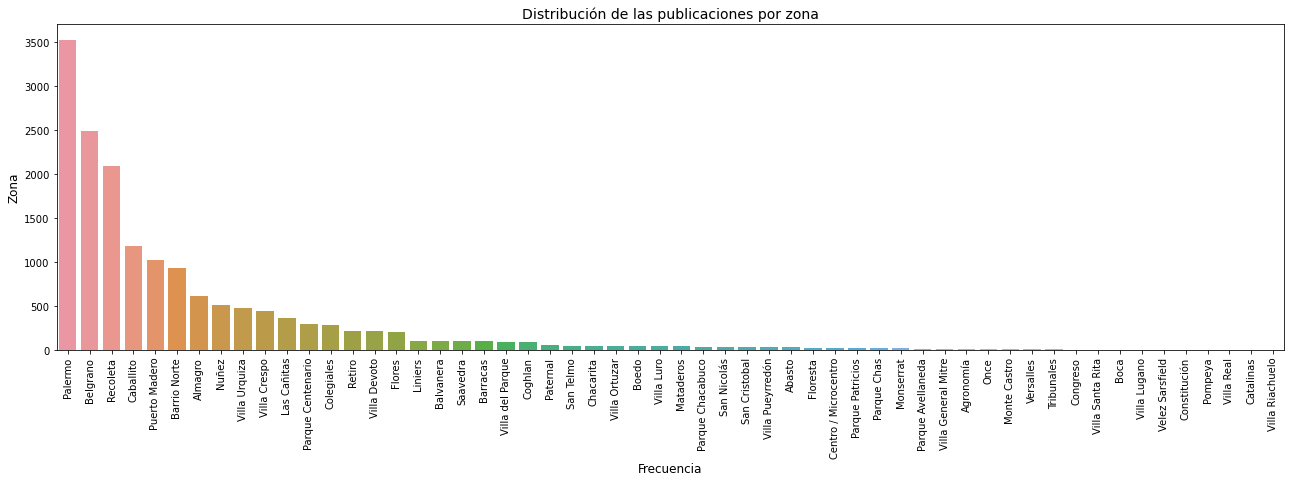

In [68]:
# Visualizar la distribución de los precios más caros por barrio:

plt.figure(figsize = (22,6))
sns.barplot(x= df_dpto_mayores["l3"].value_counts().index, y = df_dpto_mayores["l3"].value_counts())
#sns.countplot(data = df_dpto_mayores, x = df_dpto_mayores["l3"].value_counts().index, order = df['l3'].value_counts().index )
plt.xticks(rotation = 90)
plt.title ("Distribución de las publicaciones por zona", fontsize= 14)

plt.ylabel('Zona', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

* El barrio de Palermo es el más caro, seguido del barrio de Belgrano y Recoleta.


In [69]:
# Efectuar un mapa de calor de las propiedades más caras de Bs. As

# Mapa de Calor de precios en la ciudad de Bs. As

#max_amount = float(df_depto['price'].max())

folium_hmap = folium.Map(location=[-34.60, -58.37],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(df_dpto_mayores['lat'], df_dpto_mayores['lon'], df_dpto_mayores['precio_mt2'])),
                   min_opacity=0.2,
                   radius=8, blur=6, 
                   max_zoom=15)

folium_hmap.add_child(hm_wide)
#folium_hmap

folium_hmap.save('Mapa precios.html')
folium_hmap

La gráfica permite observar que los barrios con precios más caros se localizan en cercanía al río, y que el barrio de Palermo prenta valores semejantes a Recoleta, Retiro, y Puerto Madero.

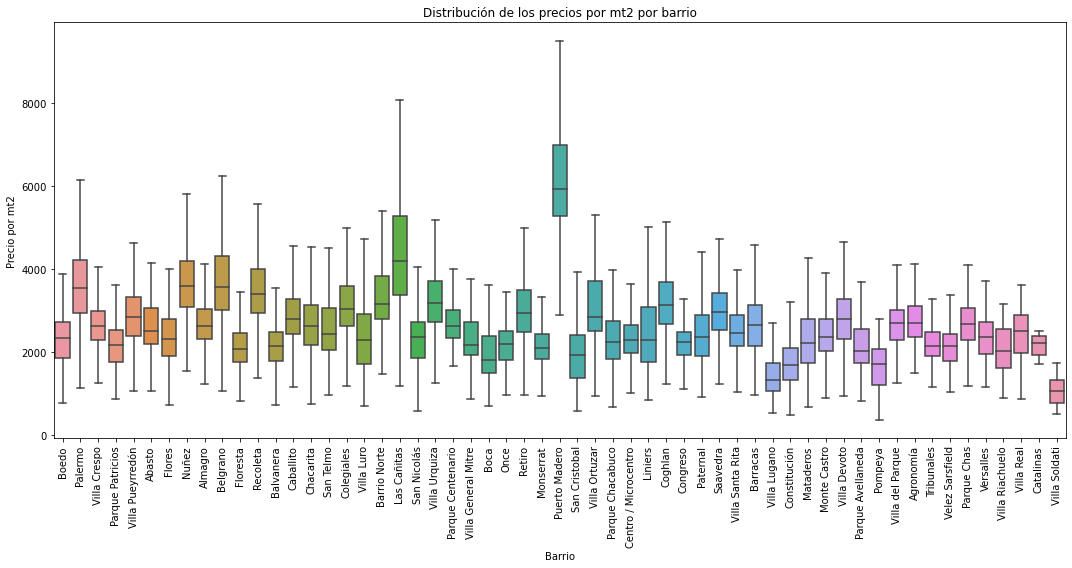

In [70]:
# Efectuar un Boxplot comparativo de precios por mt2 por barrio, filtrando outliers

plt.figure(figsize = (15,8))
sns.boxplot(data = df_capital, x = "l3", y = "precio_mt2", showfliers = False)
plt.title("Distribución de los precios por mt2 por barrio")
plt.xlabel("Barrio")
plt.ylabel("Precio por mt2")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

* Los valores de precio por mt2 presentan una distribución donde existen barrios con valores con valores mínimos superiores al resto, y a simple vista se observan barrios que presentan distribuciones similares. El barrio de Palermo es uno de los barrios que presenta sus valores por metro cuadrado superiores al resto de los barrios.

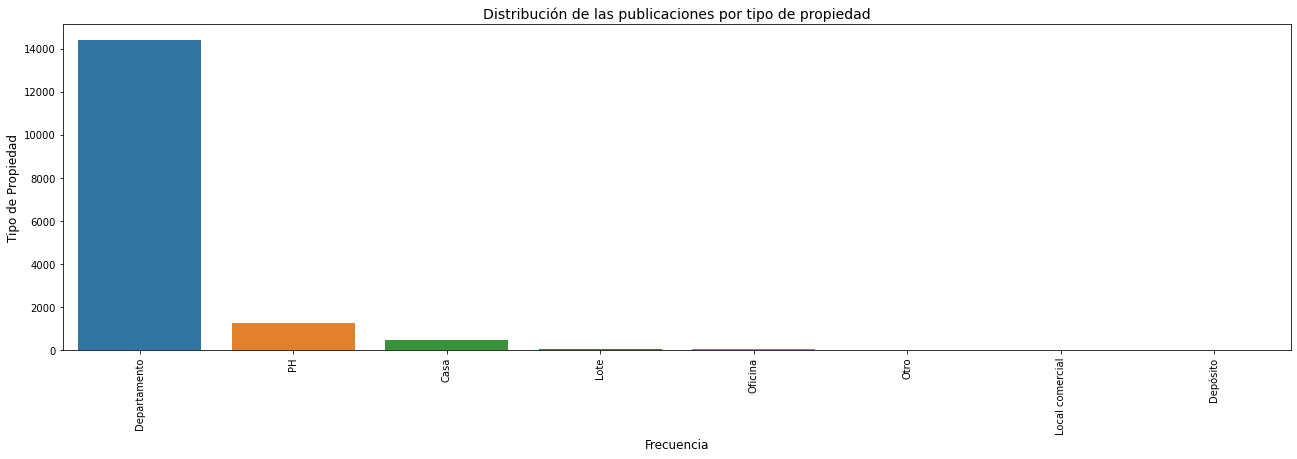

In [71]:
# Visualizar la distribución de los precios más tipo de propiedad:

plt.figure(figsize = (22,6))
sns.barplot(x= df_dpto_mayores["property_type"].value_counts().index, y = df_dpto_mayores["property_type"].value_counts())
#sns.countplot(data = df_dpto_mayores, x = df_dpto_mayores["l3"].value_counts().index, order = df['l3'].value_counts().index )
plt.xticks(rotation = 90)
plt.title ("Distribución de las publicaciones por tipo de propiedad", fontsize= 14)

plt.ylabel('Tipo de Propiedad', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

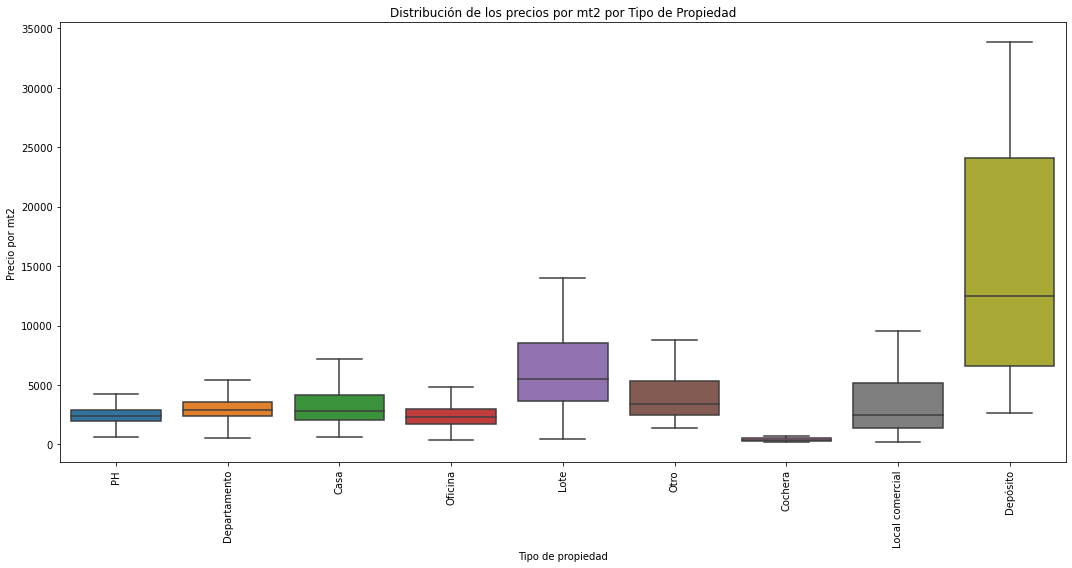

In [72]:
# Efectuar un Boxplot comparativo de precios por mt2 por tipo de propiedad, filtrando outliers

plt.figure(figsize = (15,8))
sns.boxplot(data = df_capital, x = "property_type", y = "precio_mt2", showfliers = False)
plt.title("Distribución de los precios por mt2 por Tipo de Propiedad")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Precio por mt2")
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

### Conclusiones del análisis exploratorio de datos de Capital Federal
Se observa que las publicaciones se presentan en una gran cantidad de barrios, pero que el 44% de las publicaciones se concentran en los barrios de Palermo, Almagro, Villa Crespo, Caballito y Belgrano.
A su vez, las publicaciones más caras se encuentran en el Barrio de Palermo, seguido de Belgrano.
El 88% de las publicaciones son departamentos.
Se llevará a cabo una predicción de precios de departamentos para el barrio de Palermo, por separado del resto, ya que es el que más publicaciones presenta como también precios más altos que pueden generar una disminución en la capacidad de predicción de tratarlo en conjunto con el resto de los barrios.
Respecto al resto de los barrios, también sería necesario efectuar más divisiones, teniendo en cuenta los mismos criterios: rango de precios y cantidad de publicaciones.

# Los departamentos en Palermo en números

In [73]:
# Generar un dataset para los datos de Palermo y departamentos

df_palermo = df_capital[df_capital.l3.isin(["Palermo"])]
print ("El shape del dataset es: " , df_palermo.shape)
df_palermo.head()

El shape del dataset es:  (11488, 20)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,precio_mt2
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta,2777.777778
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,5900.000000
34,2019-10-17,2019-10-31,2019-10-17,-34.590031,-58.423771,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,52.0,48.0,188000.0,USD,Departamento de 2 ambientes en Venta en Palerm...,Excelente departamento de dos ambientes. Unida...,Departamento,Venta,3916.666667
35,2019-10-17,2019-12-23,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,USD,Nuevo Ingreso Palacio Bellini Alquiler,Excelente departamento de dos ambientes de 81m...,Departamento,Venta,5394.736842
36,2019-10-17,2019-10-27,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,42.0,38.0,169000.0,USD,Precioso Departamento con cochera Zona univer...,Excelente ubicación a una cuadra y media de av...,Departamento,Venta,4447.368421


### Comparación de los departamentos de palermo vs el resto de los barrios
Se creará un dataset con los barrios de Capital Federal, sin considadera el barrio de Palermo.
Con este objetivo, se pretende poder comparar el barrio de Palermo con el resto de los barrios.

In [74]:

df_sin_palermo = df_capital[~df_capital.l3.isin(["Palermo"])]
print ("El shape del dataset es: " , df_sin_palermo.shape)
df_sin_palermo.head()

El shape del dataset es:  (70381, 20)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,precio_mt2
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,2741.379310
5,2019-10-17,2019-11-01,2019-10-17,-34.593779,-58.441239,Argentina,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Excelente ph solo 2 unidades, no paga expensas...",PH,Venta,2678.571429
6,2019-10-17,2019-10-31,2019-10-17,-34.600988,-58.433061,Argentina,Capital Federal,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Muy lindo PH, con terraza propia, 96m2! por es...",PH,Venta,2278.571429
7,2019-10-17,2019-10-31,2019-10-17,-34.600988,-58.433061,Argentina,Capital Federal,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,USD,Depto.tipo casa de 2 ambientes en Venta en Vil...,"Muy lindo PH, con terraza propia, 96m2! por es...",PH,Venta,2278.571429
8,2019-10-17,2019-12-23,2019-10-17,-34.639598,-58.419612,Argentina,Capital Federal,Parque Patricios,1.0,1.0,1.0,45.0,37.0,89000.0,USD,"PH SIN EXPENSAS, AMPLIO MONOAMBIENTE DIVISIBLE...","VENTA DE PH, EN EXCELENTE ESTADO, EN PARQUE PA...",PH,Venta,2405.405405


In [75]:
# Iniciamos con una descripción de las estadísticas de cada variable numérica:
df_sin_palermo.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,precio_mt2
count,70381.000000,70381.000000,70381.000000,70381.000000,70381.000000,70381.000000,70381.000000,7.038100e+04,70381.000000
mean,-34.601132,-58.438744,2.725679,1.779031,1.396485,74.518975,65.620906,1.945682e+05,3087.569268
std,0.024022,0.036940,1.048732,0.904690,0.651654,32.375144,27.571991,1.384259e+05,6362.775027
min,-34.696419,-58.530467,1.000000,0.000000,1.000000,15.000000,1.000000,7.500000e+03,176.470588
25%,-34.615749,-58.462815,2.000000,1.000000,1.000000,50.000000,44.000000,1.130000e+05,2244.444444
50%,-34.602133,-58.441283,3.000000,2.000000,1.000000,72.000000,63.000000,1.590000e+05,2750.000000
75%,-34.590008,-58.410098,3.000000,2.000000,2.000000,88.000000,77.000000,2.350000e+05,3375.000000
max,-34.535818,-58.353930,7.000000,6.000000,4.000000,183.000000,156.000000,4.144561e+06,980000.000000


### Características de los departamentos del barrio de Palermo

In [76]:
# Almacenar los valores promedios de las principales variables para Palermo y el resto:

precio_palermo = df_palermo.price.mean()
precio_resto = df_sin_palermo.price.mean()
precio_m2_palermo = df_palermo.precio_mt2.mean()
precio_m2_resto = df_sin_palermo.precio_mt2.mean()
sup_total_palermo = df_palermo.surface_total.mean()
sup_total_resto = df_sin_palermo.surface_total.mean()
hab_palermo = df_palermo.rooms.mean()
hab_resto = df_sin_palermo.rooms.mean()
dormitorios_palermo = df_palermo.bedrooms.mean()
dormitorios_resto = df_sin_palermo.bedrooms.mean()
baños_palermo = df_palermo.bathrooms.mean()
baños_resto = df_sin_palermo.bathrooms.mean()



In [77]:
comparativo = pd.DataFrame({"Features": ["Precio", "Precio m2", "Sup Total", "Habitaciones", "Dormitorios", "Baños"],
"Palermo" : [precio_palermo, precio_m2_palermo, sup_total_palermo, hab_palermo, dormitorios_palermo, baños_palermo], 
"Resto_de_los_Barrios": [precio_resto, precio_m2_resto, sup_total_resto, hab_resto, dormitorios_resto, baños_resto]})

comparativo = comparativo.set_index('Features')
comparativo

,Palermo,Resto_de_los_Barrios
Features,,
Precio,250465.472754,194568.199898
Precio m2,3836.582130,3087.569268
Sup Total,74.264015,74.518975
Habitaciones,2.684105,2.725679
Dormitorios,1.735637,1.779031
Baños,1.427751,1.396485


In [78]:
# Calculamos las diferencias en porcentajes entre las variables 
comparativo ["diferencia"] = (comparativo["Resto_de_los_Barrios"] - comparativo ["Palermo"]) / comparativo ["Palermo"]
comparativo

,Palermo,Resto_de_los_Barrios,diferencia
Features,,,
Precio,250465.472754,194568.199898,-0.223174
Precio m2,3836.582130,3087.569268,-0.195229
Sup Total,74.264015,74.518975,0.003433
Habitaciones,2.684105,2.725679,0.015489
Dormitorios,1.735637,1.779031,0.025002
Baños,1.427751,1.396485,-0.021899


La comparación permite determinar que el precio promedio del barrio de Palermo es un 25,95% superior al precio promedio del resto de los barrios.
* El precio por metro cuadrado promedio de en el barrio de palermo es un 19,59 % superior al resto de los barrios de Capital Federal.
* La Superficie total promedio en el barrio de Palermo es un 5% superior al resto de los barrios de Capital Federal.
No hay diferencias en la cantidad de habitaciones, dormitorios y baños en términos medios entre Palermo y el resto de los barrios.

In [79]:
# Verificar la presencia de outliers en las variables del Dataset de Palermo

print('Rango mínimo y máximo para Superficie total:',outlier_treatment(df_palermo.surface_total), sep = '\n')
print('Rango mínimo y máximo para Superficie cubierta:',outlier_treatment(df_palermo.surface_covered), sep = '\n')
print('Rango mínimo y máximo para precio:',outlier_treatment(df_palermo.price), sep = '\n')
print('Rango mínimo y máximo para cantidad de habitaciones:',outlier_treatment(df_palermo.rooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de dormitorios:',outlier_treatment(df_palermo.bedrooms), sep = '\n')
print('Rango mínimo y máximo para cantidad de baños:',outlier_treatment(df_palermo.bathrooms), sep = '\n')

Rango mínimo y máximo para Superficie total:
(-9.5, 146.5)
Rango mínimo y máximo para Superficie cubierta:
(-10.0, 134.0)
Rango mínimo y máximo para precio:
(-73000.0, 519000.0)
Rango mínimo y máximo para cantidad de habitaciones:
(0.5, 4.5)
Rango mínimo y máximo para cantidad de dormitorios:
(-0.5, 3.5)
Rango mínimo y máximo para cantidad de baños:
(-0.5, 3.5)


In [80]:
# Remover los valores extremos de cada variable y almacenar en un nuevo dataset:



df_palermo_filtrado=df_palermo[(df_palermo.bathrooms <= 4) & (df_palermo.bedrooms<= 5) & (df_palermo.rooms<= 4)& (df_palermo.surface_total<= 138) & (df_palermo.surface_covered<= 124) & (df_palermo.price<= 467375)]


df_palermo_filtrado.head ()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,precio_mt2
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta,2777.777778
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta,5900.000000
34,2019-10-17,2019-10-31,2019-10-17,-34.590031,-58.423771,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,52.0,48.0,188000.0,USD,Departamento de 2 ambientes en Venta en Palerm...,Excelente departamento de dos ambientes. Unida...,Departamento,Venta,3916.666667
35,2019-10-17,2019-12-23,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,USD,Nuevo Ingreso Palacio Bellini Alquiler,Excelente departamento de dos ambientes de 81m...,Departamento,Venta,5394.736842
36,2019-10-17,2019-10-27,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,42.0,38.0,169000.0,USD,Precioso Departamento con cochera Zona univer...,Excelente ubicación a una cuadra y media de av...,Departamento,Venta,4447.368421


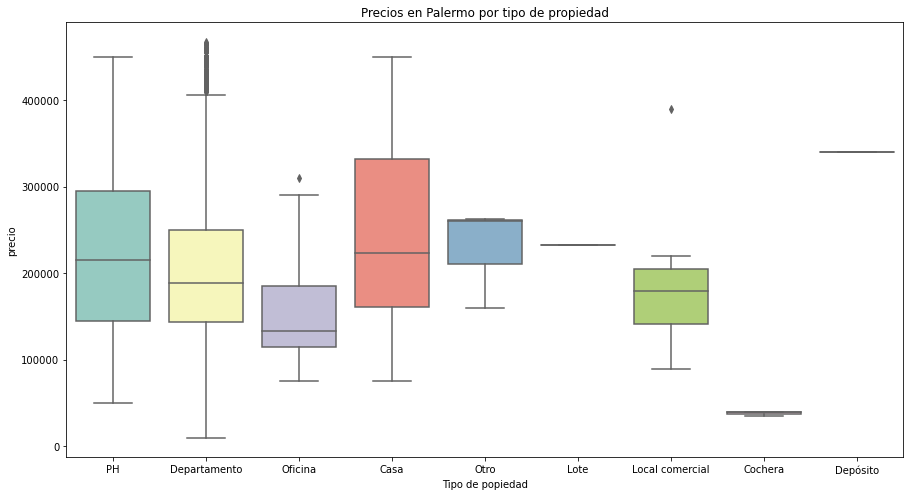

In [81]:
# Verificar los precios en palermo por tipo de propiedad 
plt.figure(figsize = (15,8))
sns.boxplot(x="property_type", y="price", data=df_palermo_filtrado, palette="Set3")
plt.title ("Precios en Palermo por tipo de propiedad")
plt.xlabel("Tipo de popiedad")
plt.ylabel("precio")
plt.show();

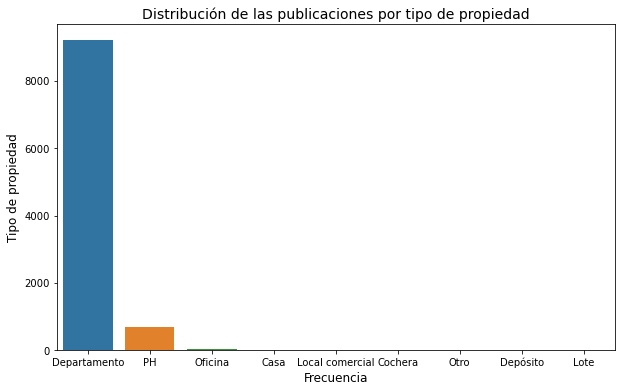

In [82]:
# Verficar la cantidad de publicaciones por tipo de propiedad:

plt.figure(figsize = (10,6))
sns.countplot(data = df_palermo_filtrado, x = "property_type", order = df_palermo_filtrado['property_type'].value_counts().index )
#plt.xticks(rotation = 90)
plt.title ("Distribución de las publicaciones por tipo de propiedad", fontsize= 14)

plt.ylabel('Tipo de propiedad', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

In [83]:
# Verificar el porcentaje de propiedades en Palermo
print (porcentajes (df_palermo_filtrado, "property_type"))

Departamento       0.926633
PH                 0.068040
Oficina            0.002714
Casa               0.001005
Local comercial    0.000804
Cochera            0.000302
Otro               0.000302
Depósito           0.000101
Lote               0.000101
Name: property_type, dtype: float64


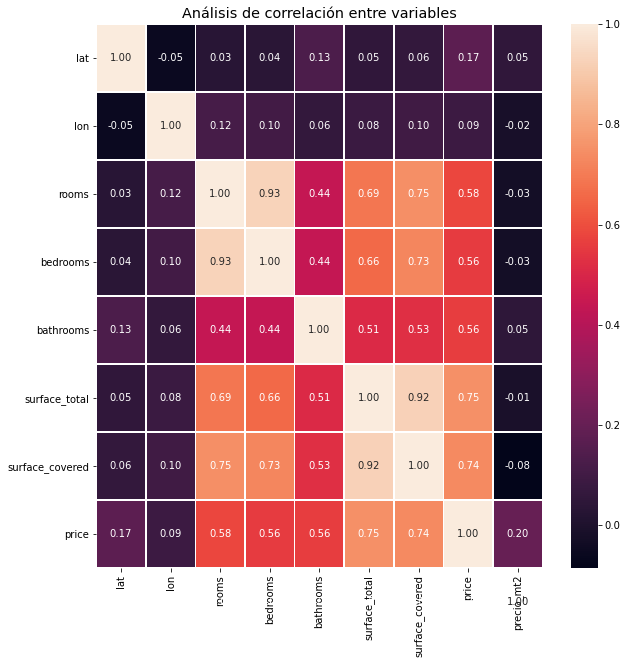

In [84]:
# Verificar la correlación de las variables con el precio

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_palermo_filtrado.corr(), annot=True, linewidths=0.5, fmt='.2f',ax=ax)
plt.title("Análisis de correlación entre variables", size = "x-large")

ax.set_ylim(8, 0);

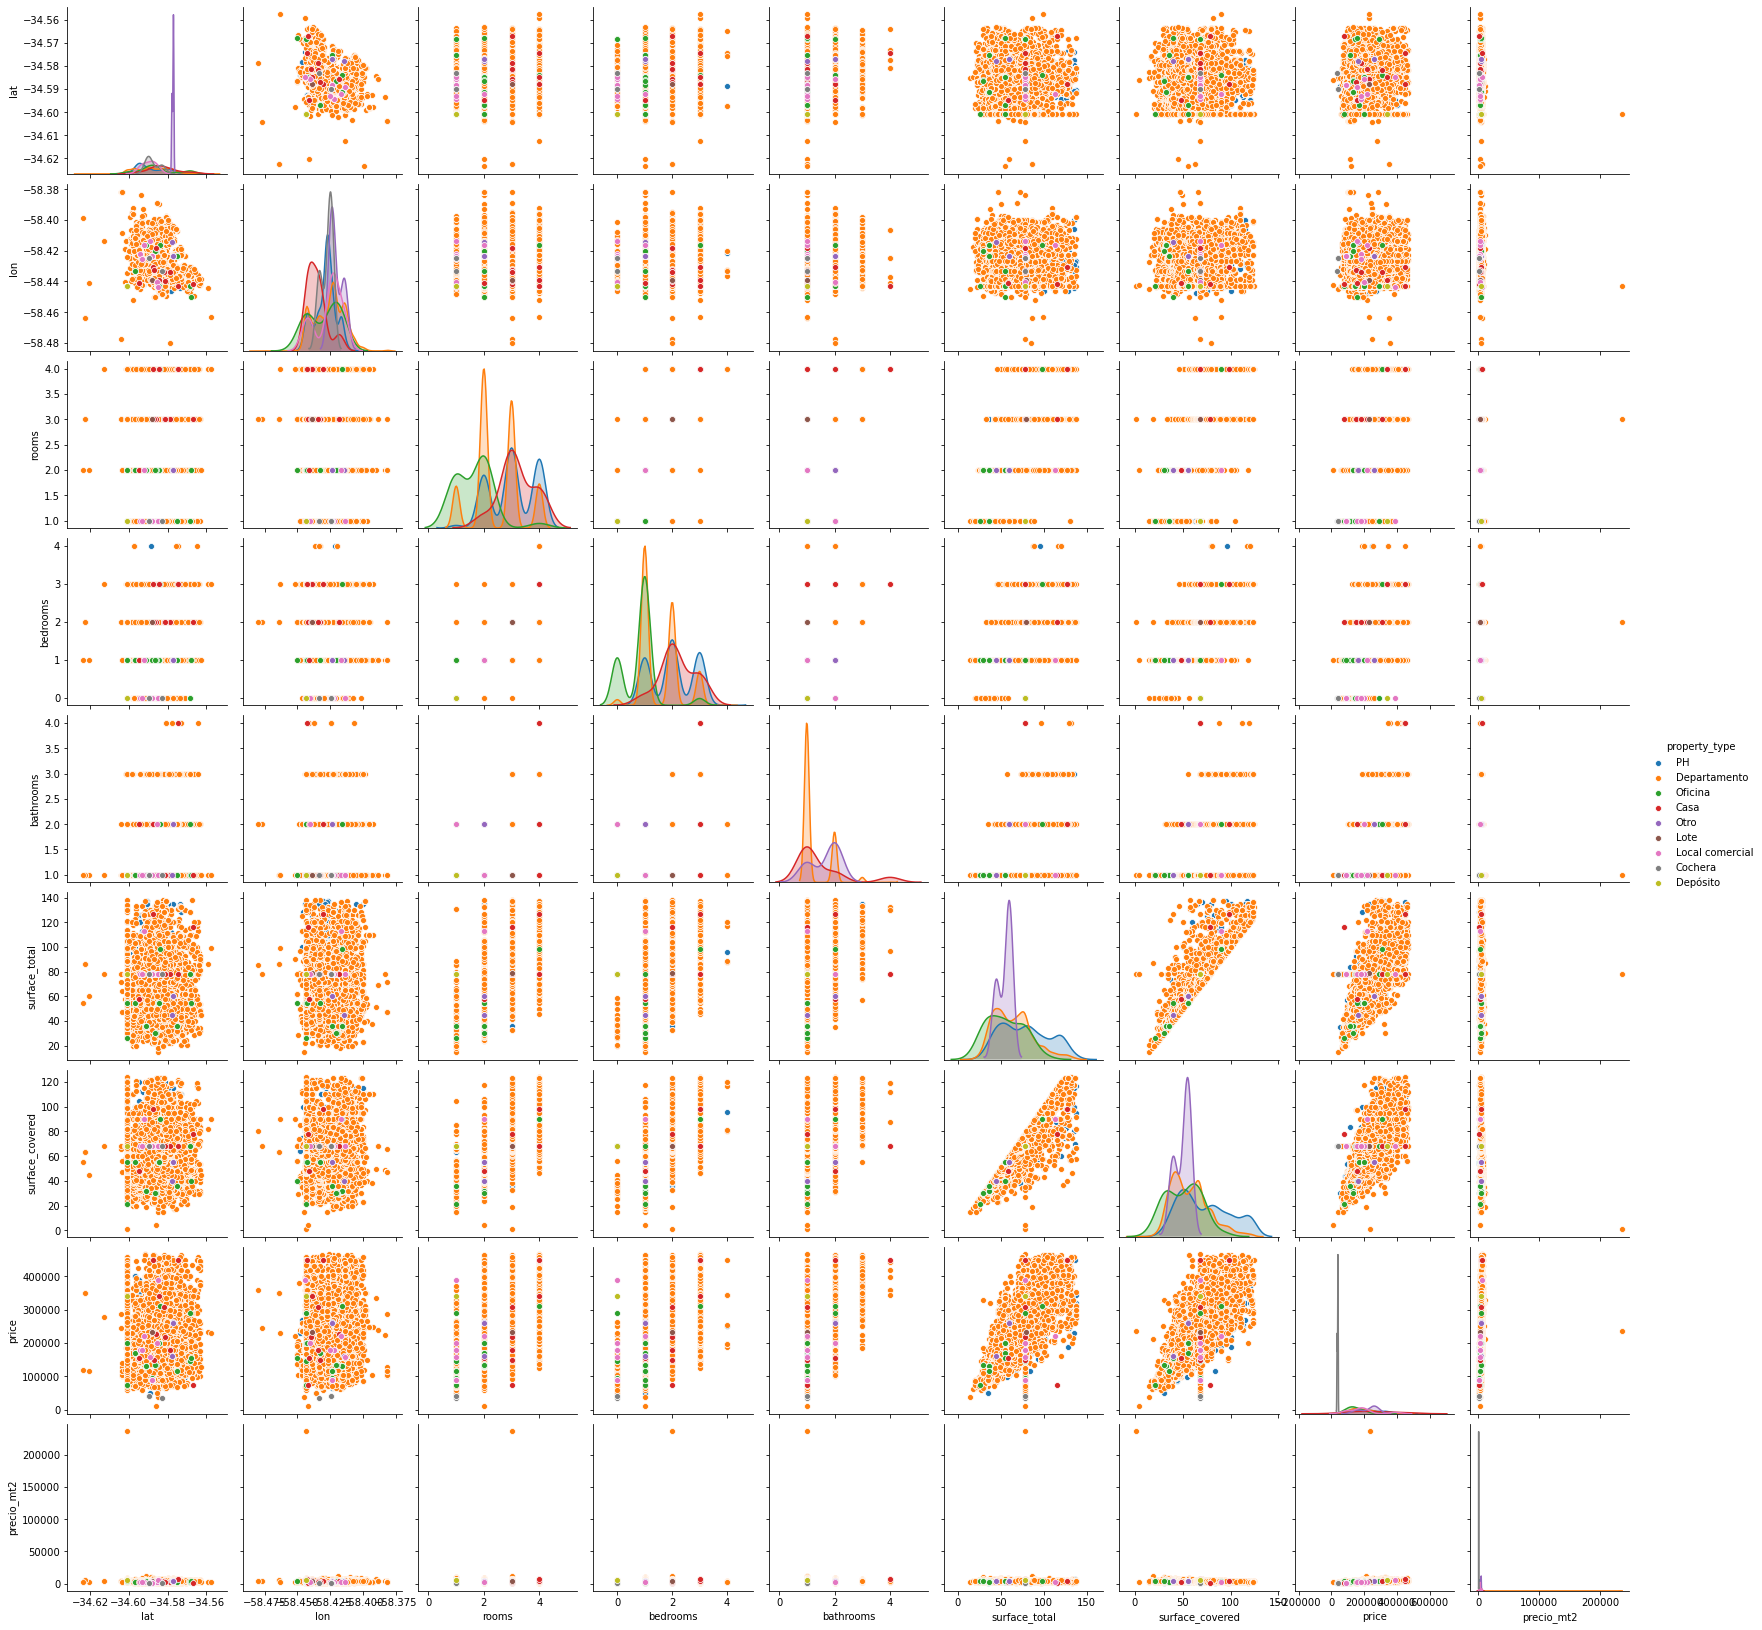

In [85]:
# Verificar una gráfica de la distribución de todas las variables, clasificadas por tipo de propiedad
np.warnings.filterwarnings('ignore')
sns.pairplot(df_palermo_filtrado, hue="property_type");

* Además de que las gráficas por el volumen disímil de datos se observa con mayor facilidad los tipos de propiedad departamentos, se puede observar que para el resto de los tipos de propiedad, no se observan valores altos de superficie cubierta, y precio, y como la distribución de las variables es muy distinta según tipo de propiedad.

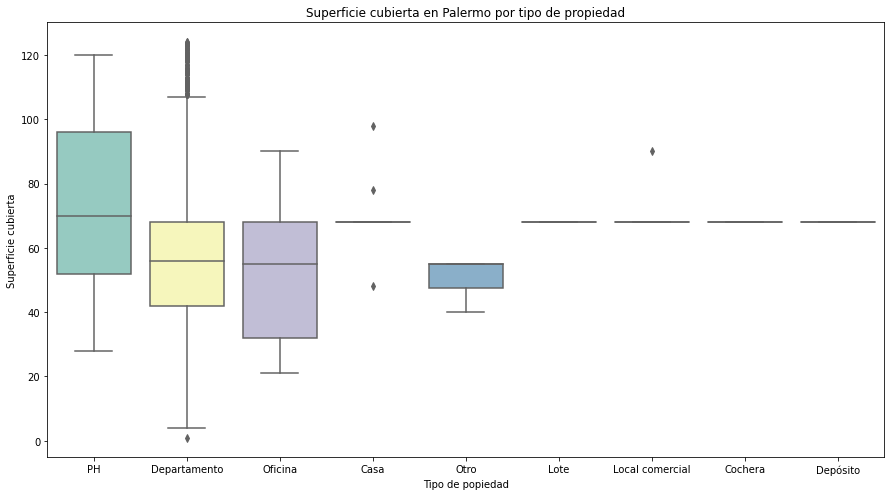

In [86]:
# Como la superficie cubierta es la variable de mayor correlación con el precio, se verifica la distribución de esta variable por tipo de propiedad
# Verificar los precios en palermo por tipo de propiedad 
plt.figure(figsize = (15,8))
sns.boxplot(x="property_type", y="surface_covered", data=df_palermo_filtrado, palette="Set3")
plt.title ("Superficie cubierta en Palermo por tipo de propiedad")
plt.xlabel("Tipo de popiedad")
plt.ylabel("Superficie cubierta")
plt.show();

* Se observa una diferencia significativa en la distribución de la superficie cubierta según tipo de propiedad. Esto, sumado a que los departamentos representan el 91% de las publicaciones, sugieren que es conveniente filtrar solo el tipo de propiedad "Departamento" para llevar a cabo las predicciones con mayor precisión y exactitud.

### Un poco más de información para elegir dónde vivir....
Cuando las personas buscan un hogar para vivir, una de las variables que se observan en la cantidad de delitos registrados en la zona.
Se tomarán los datos publicados por el Gobierno de la ciudad de Buenos Aires para llevar a cabo un mapa del delito del año 2019.
Fuente: https://data.buenosaires.gob.ar/dataset/delitos/archivo/2928d01c-c186-4250-8998-4610abfef95b

In [87]:
df_delitos = pd.read_csv ("delitos_2019.csv")
print(" El shape del dataset es de: " , df_delitos.shape)
df_delitos.head()

 El shape del dataset es de:  (117661, 10)


,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long
0,374556,2019-01-01,12,Lesiones,Siniestro Vial,1.0,4.0,Nueva Pompeya,-34.648387,-58.404748
1,426152,2019-01-01,6,Robo (con violencia),NaN,1.0,9.0,Liniers,-34.649827,-58.513859
2,371604,2019-01-01,8,Lesiones,Siniestro Vial,1.0,15.0,Chacarita,-34.588108,-58.439392
3,425359,2019-01-01,16,Hurto (sin violencia),Hurto Automotor,1.0,10.0,Floresta,-34.631877,-58.483975
4,437571,2019-01-01,2,Robo (con violencia),Robo Automotor,1.0,4.0,Parque Patricios,-34.633161,-58.397123


In [88]:
# Nombres de columnas y valores faltantes por cada una:
df_delitos.isnull().sum()

id                          0
fecha                       0
franja_horaria              0
tipo_delito                 0
subtipo_delito         105985
cantidad_registrada         0
comuna                    597
barrio                    597
lat                       597
long                      597
dtype: int64

La variable subtipo de delito posee gran cantidad de valores nulos, por lo que no podrá ser tenida en cuenta.
Para el resto de las variables, como la cantidad de registros son despreciables, se procede a eliminarlas.

In [89]:
# Eliminación de la columna "subtipo_delito"
df_delitos = df_delitos.drop(columns=['subtipo_delito'])

# Eliminación de valores nulos de las variables "comuna", "barrio", "lat", "long":
df_delitos = df_delitos.dropna()
# Eliminación de la columna "subtipo_delito"
df_delitos.isnull().sum()

id                     0
fecha                  0
franja_horaria         0
tipo_delito            0
cantidad_registrada    0
comuna                 0
barrio                 0
lat                    0
long                   0
dtype: int64

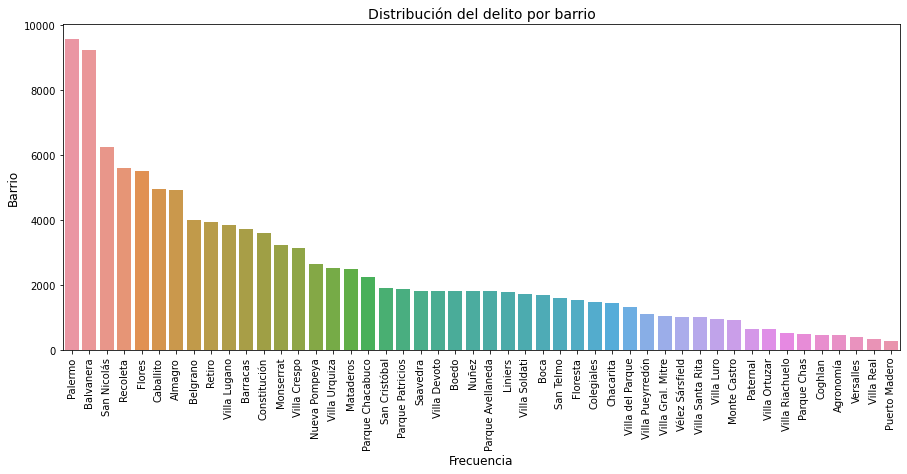

In [90]:
# Comparar la cantidad de delitos por barrio
plt.figure(figsize = (15,6))
sns.countplot(data = df_delitos, x = "barrio", order = df_delitos['barrio'].value_counts().index )
plt.xticks(rotation = 90)
plt.title ("Distribución del delito por barrio", fontsize= 14)

plt.ylabel('Barrio', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

In [91]:
# Verificar los porcentajes de delitos por barrio
print (porcentajes (df_delitos, "barrio"))

Palermo              0.081656
Balvanera            0.078923
San Nicolás          0.053355
Recoleta             0.047743
Flores               0.047137
Caballito            0.042387
Almagro              0.041977
Belgrano             0.034195
Retiro               0.033588
Villa Lugano         0.032794
Barracas             0.031692
Constitución         0.030684
Monserrat            0.027558
Villa Crespo         0.026857
Nueva Pompeya        0.022654
Villa Urquiza        0.021518
Mataderos            0.021330
Parque Chacabuco     0.019220
San Cristóbal        0.016196
Parque Patricios     0.016017
Saavedra             0.015632
Villa Devoto         0.015556
Boedo                0.015427
Nuñez                0.015410
Parque Avellaneda    0.015402
Liniers              0.015231
Villa Soldati        0.014659
Boca                 0.014377
San Telmo            0.013625
Floresta             0.013283
Colegiales           0.012540
Chacarita            0.012395
Villa del Parque     0.011208
Villa Puey

* El barrio de Palermo es el barrio que más delitos presenta registrados en Capital Federal, representando un 8% de los casos.
* Los barrios de Villa Real y  Puerto Madero son los que registran menor cantidad de delitos registrados.

Robo (con violencia)     0.492834
Hurto (sin violencia)    0.466994
Lesiones                 0.039335
Homicidio                0.000837
Name: tipo_delito, dtype: float64


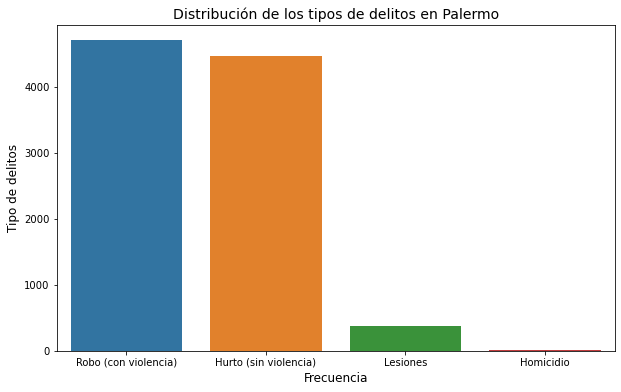

In [92]:
# Verificar los tipos de delitos que se registran en Palermo:
print (porcentajes (df_delitos[df_delitos.barrio.isin(["Palermo"])], "tipo_delito"))

# Graficar la Cantidad de Delitos:

plt.figure(figsize = (10,6))
sns.countplot(data = df_delitos[df_delitos.barrio.isin(["Palermo"])], x = "tipo_delito", order = df_delitos['tipo_delito'].value_counts().index )
#plt.xticks(rotation = 90)
plt.title ("Distribución de los tipos de delitos en Palermo", fontsize= 14)

plt.ylabel('Tipo de delitos', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

* La mayoría de los tipos de delitos en el barrio se encuentran igualmente distribuidos entre robos con y sin violencia.

Robo (con violencia)     0.538933
Hurto (sin violencia)    0.415785
Lesiones                 0.043635
Homicidio                0.001646
Name: tipo_delito, dtype: float64


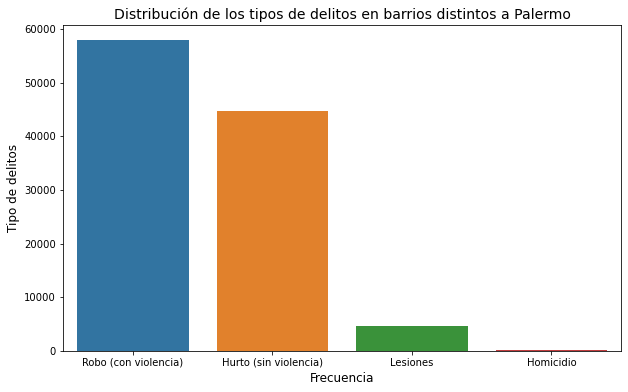

In [93]:
# Verificar los tipos de delitos que se registran en el barrio de Palermo:

print (porcentajes (df_delitos[~df_delitos.barrio.isin(["Palermo"])], "tipo_delito"))



# Graficar la Cantidad de Delitos:

plt.figure(figsize = (10,6))
sns.countplot(data = df_delitos[~df_delitos.barrio.isin(["Palermo"])], x = "tipo_delito", order = df_delitos['tipo_delito'].value_counts().index )
#plt.xticks(rotation = 90)
plt.title ("Distribución de los tipos de delitos en barrios distintos a Palermo", fontsize= 14)

plt.ylabel('Tipo de delitos', fontsize=12)
plt.xlabel('Frecuencia', fontsize=12)
plt.show();

* En el resto de los barrios, la brecha entre robos con violencia y sin crece levente, y se presentan mayor cantidad de casos de lesiones (cuales pueden ser delitos de violencia de género, por ejemplo)

### ¿Los precios publicados por la Inmobiliaria... Son lógicos?
* A la hora de comprar un inmueble, como se trata de un bien de larga duración y con vista a futuro, se analiza el precio del terreno. Esto también ayuda a comprender si el precio del inmueble construido el lógico o no.
Se analizar los precios de los terrenos a partir de la información publicada por el gobierno de la ciudad Buenos Aires:


In [94]:
precios_terrenos =  pd.read_csv("precio-de-terrenos-2018.csv")
precios_terrenos.head()

,operacion,tipo,long,lat,m2total,direccion,calle,altura,cambio,preciotex,preciousd,precioars,preciousdm,precioarsm,barrio,comuna,codigo_postal,codigo_postal_argentino
0,VTA,TERRENO,-58.414071,-34.618214,320.0,Agrelo 3399,Agrelo,3399.0,37.2,U$S 330000,330000.0,12276000.0,1031.250000,38362.500000,ALMAGRO,5.0,1224.0,C1224ABE
1,VTA,TERRENO,-58.424566,-34.610097,320.0,Bartolome Mitre y Gascon,Bartolome Mitre y Gascon,NaN,37.2,U$S 690000,690000.0,25668000.0,2156.250000,80212.500000,ALMAGRO,5.0,NaN,NaN
2,VTA,TERRENO,-58.424486,-34.613659,174.0,Don Bosco,Don Bosco,NaN,37.2,U$S 380000,380000.0,14136000.0,2183.908046,81241.379310,ALMAGRO,5.0,NaN,NaN
3,VTA,TERRENO,-58.423651,-34.614752,650.0,Hipolito Irigoyen 4043,Hipolito Irigoyen,4043.0,37.2,U$S 1000000,1000000.0,37200000.0,1538.461538,57230.769231,ALMAGRO,5.0,NaN,NaN
4,VTA,TERRENO,-58.413725,-34.603124,283.0,HUMAHUACA 3400,HUMAHUACA,3400.0,37.2,U$S 850000,850000.0,31620000.0,3003.533569,111731.448763,ALMAGRO,5.0,1191.0,C1191ABB


In [95]:
# Controlar la cantidad de registros del dataset
precios_terrenos.shape

(902, 18)

In [96]:
# Nombres de columnas y valores faltantes por cada una:
precios_terrenos.isnull().sum()

operacion                    0
tipo                         0
long                         0
lat                          0
m2total                      0
direccion                    1
calle                        4
altura                      90
cambio                       0
preciotex                    0
preciousd                    0
precioars                    0
preciousdm                   0
precioarsm                   0
barrio                       1
comuna                       0
codigo_postal              167
codigo_postal_argentino    167
dtype: int64

In [97]:
#Instancias por cada tipo de propiedad
precios_terrenos["barrio"].value_counts()

PALERMO              64
FLORES               58
CABALLITO            53
BALVANERA            50
VILLA CRESPO         48
ALMAGRO              39
VILLA URQUIZA        38
BELGRANO             34
MATADEROS            28
VILLA DEL PARQUE     27
SAAVEDRA             26
PARQUE CHACABUCO     25
PARQUE PATRICIOS     24
BARRACAS             20
VILLA ORTUZAR        20
CHACARITA            19
VILLA SANTA RITA     18
VILLA GRAL. MITRE    18
MONTE CASTRO         18
FLORESTA             18
LINIERS              18
BOEDO                17
VILLA DEVOTO         17
VILLA LURO           15
CONSTITUCION         14
MONTSERRAT           14
SAN CRISTOBAL        14
PARQUE AVELLANEDA    13
COLEGIALES           13
NUEVA POMPEYA        12
BOCA                 10
VILLA PUEYRREDON     10
COGHLAN               9
NUâ”œÃ¦EZ             9
PARQUE CHAS           9
RECOLETA              9
PATERNAL              8
SAN NICOLAS           7
VILLA LUGANO          7
SAN TELMO             7
NUÃ‘EZ                6
AGRONOMIA       

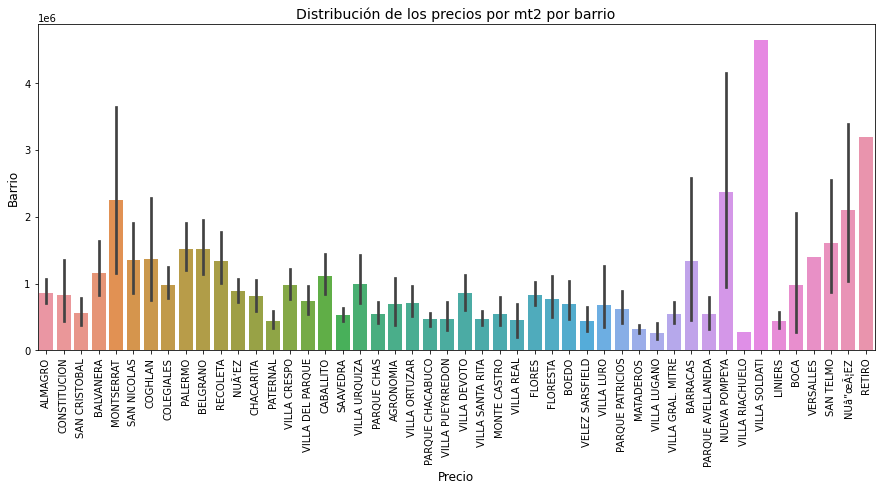

In [98]:
# Comparar la el precio por metro cuadrado por barrio
plt.figure(figsize = (15,6))
sns.barplot(data = precios_terrenos, x = "barrio", y = "preciousd" )
plt.xticks(rotation = 90)
plt.title ("Distribución de los precios por mt2 por barrio", fontsize= 14)

plt.ylabel('Barrio', fontsize=12)
plt.xlabel('Precio', fontsize=12)
plt.show();

* Los barrios con precios de terrenos por metro cuadrado más alto son Villa Soldatti, Retiro, Parque Avellaneda, Monserrat San Telmo.

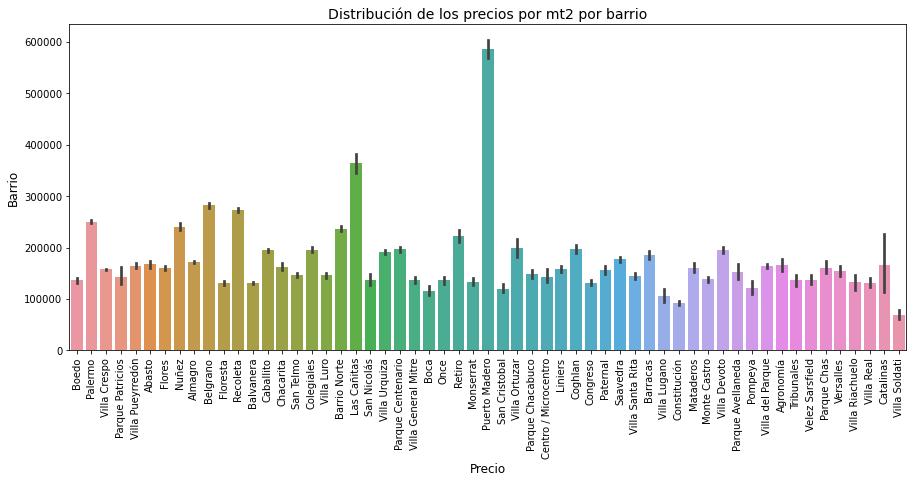

In [99]:
# Comparar por con los precios por metro Cuadrado por Barrio de la inmobiliaria
plt.figure(figsize = (15,6))
sns.barplot(data = capital, x = "l3", y = "price" )
plt.xticks(rotation = 90)
plt.title ("Distribución de los precios por mt2 por barrio", fontsize= 14)

plt.ylabel('Barrio', fontsize=12)
plt.xlabel('Precio', fontsize=12)
plt.show();

* La inmmobiliaria posee precios por metro cuadrado contruido donde Puerto Madero, Barrio Norte, Las Cañitas Recoleta y Belgrano y luego Palermo son los más caros. 
Se puede deducir que los precios publicados por la inmobiliaria para el barrio de Palermo siguen la lógica de orden de precios por metro cuadrado de los terrenos, por lo que los precios no son fijados al azar si no que se tiene en cuenta a demás esta variable.

 ## Conclusiones generales del análisis exploratorio de datos
 Se llevó a cabo un análisis exploratorio del dataset de una Inmobiliaria para las publicaciones de Venta de Capital Federal y Gran Buenos Aires.
 Se observó que la mayoría de las publicaciones de la inmobiliaria son departamentos del barrio de Palermo, que a su vez presenta los mayores precios, generando falta de representatividad en los datos disponibles del resto de las categorías de zonas, barrios y tipos de propiedad.
 En el barrio de Palermo a su vez, la mayoría de las publicaciones son departamentos.
 La variable superficie cubierta es la que presenta mayor correlación lineal con el precio de la publicación. Esta variable a su vez, presenta una dispersión significativa de acuerdo al tipo de propiedad, por lo que analizar todos los tipos de propiedad juntos, puede generar distorciones en las predicciones.
 Se concluye que para llevar a cabo las predicciones de precios, es necesario segmentar el dataset por separando el barrio de Palermo del resto de los barrios, como también y dentro del barrio de palermo el tipo de propiedad departamento.
 
 Se llevó a cabo un análisis adicional del barrio de Palermo, con el objetivo de analizar otras variables que toma en cuenta el probable comprador. 
 Se pudo determinar que en Palermo es el barrio con mayor cantidad de delitos denunciados de acuerdo al Gobierno de la ciudad de Buenos Aires. A su vez, el precio por metro cuadrado de los terrenos es de un precio entre los 10 más caro de la ciudad, coincidiendo con los valor del precio por metro cuadrado de la inmobiliaria.

# Modelos de predicción
Se construirá un modelo de predicción de precios para los departamentos en el barrio de Palermo.
Se tendrán en cuenta los datos de outliers de cada una de las features para definir el dataset de predicción.
Los pasos a seguir son los que se describen a continuación:
1. Preparado del Dataset: generar el dataset de train y test con las variables de estudio.
2. Escalado de datos: llevar los datos a la misma unidad de medida.
3. Seleccionar el modelo de Benchmarking: elegir un modelo de comparación base.
4. Selección de los modelos de predicción: elegir los modelos a aplicar.
5. Seleccionar la métrica de evaluación: elegir las métricas con las que se evaluarán las predicciones.
7. Implementar los modelos de predicción: implementar los modelos, efectuando cross validation y optimización de hiperparámetros.
8. Comparación de resultados: comparar las métricas de cada modelo y elegir el más óptimo.


### Preparado del dataset 
1. Del dataset de Palermo, conservar solo el tipo de propiedad Departamento.
2. Elegir las variables para efectuar las predicciones (aquellas con correlación significativa):
* Superficie total
* Superficie cubierta
* Cantidad de baños
* Cantidad de habitaciones
* Cantidad de dormitorios

In [100]:
# Conservar en el dataset de Palermo solo el tipo de propiedad Departamento:
df_palermo_dpto = df_palermo[df_palermo.property_type.isin(["Departamento"])]
print ("El shape del dataset es: " , df_palermo_dpto.shape)
df_palermo_dpto.head()

El shape del dataset es:  (10574, 20)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,precio_mt2
34,2019-10-17,2019-10-31,2019-10-17,-34.590031,-58.423771,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,52.0,48.0,188000.0,USD,Departamento de 2 ambientes en Venta en Palerm...,Excelente departamento de dos ambientes. Unida...,Departamento,Venta,3916.666667
35,2019-10-17,2019-12-23,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,2.0,81.0,76.0,410000.0,USD,Nuevo Ingreso Palacio Bellini Alquiler,Excelente departamento de dos ambientes de 81m...,Departamento,Venta,5394.736842
36,2019-10-17,2019-10-27,2019-10-17,-34.600943,-58.443262,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,42.0,38.0,169000.0,USD,Precioso Departamento con cochera Zona univer...,Excelente ubicación a una cuadra y media de av...,Departamento,Venta,4447.368421
37,2019-10-17,2019-12-23,2019-10-17,-34.584424,-58.419812,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,39.0,39.0,120000.0,USD,Armenia 2400 Palermo 2amb U$120.000 Apto Cred ...,Apto crédito. Apto profesional. Departamento d...,Departamento,Venta,3076.923077
38,2019-10-17,2019-10-22,2019-10-17,-34.597613,-58.416688,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,49.0,41.0,169000.0,USD,Oportunidad - CON COCHERA !! Excelente ubicaci...,Para Visitarlo contactarse al 01161534481 Mart...,Departamento,Venta,4121.951220


In [101]:
# Eliminar las columnas que no se necesitarán de Zona y Precio y creamos la variable X:
X = df_palermo_dpto.drop(columns=["lat", "lon", "start_date", "end_date", "created_on", "l1", "l2", "l3", "currency", "title", "description", "property_type", "operation_type", "price", "precio_mt2"])
print (X.shape)
X.head()

(10574, 5)


,rooms,bedrooms,bathrooms,surface_total,surface_covered
34,2.0,1.0,1.0,52.0,48.0
35,2.0,1.0,2.0,81.0,76.0
36,2.0,1.0,1.0,42.0,38.0
37,2.0,1.0,1.0,39.0,39.0
38,2.0,1.0,1.0,49.0,41.0


In [102]:
# Crear la variable y
y = df_palermo_dpto.loc[:, ["price"]]
print (y.shape)
y.head()

(10574, 1)


,price
34,188000.0
35,410000.0
36,169000.0
37,120000.0
38,169000.0


#### Análisis de la importancia de las Features:
En el análisis exploratorio de datos, se llevó a cabo un análisis de correlación para determinar las variables de predicción a utilizar. 
Se puede ahondar en esta información, determinando precio a generar los modelos de predicción la importancia de las features.
    

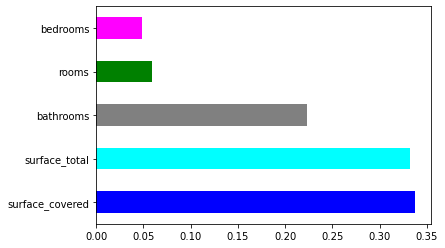

In [103]:
model_extra_tree = ExtraTreesRegressor(random_state = 42)
model_extra_tree.fit(X, y)
feature_importances = pd.Series(model_extra_tree.feature_importances_, index=X.columns)
feature_importances.nlargest(8).plot(kind='barh', color =['blue', "cyan", 'grey', 'green', 'magenta']);

Se puede observar que la superficie total y cubierta presentan una alta relevancia como se observó a través del análisis de correlación, mientras que la cantidad de baños representa el 0.2 de la importancia de los datos, siendo casi la mitad de la variable más importante (superficie total).

In [104]:
# Separar las bases de Train y Test:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Escalado de variables
Como a través del análisis exploratorio se había observado que las variables superficie total y cubierta, presentan valores máximos muy distintos al rango del resto de las variables, es conveniente llevar a cabo un escalado de los datos con el objetivo de llevar todas las variables dentro del mismo rango de medida.
##### Existen diversas técnicas de escalado, cuya selección depende de la características de los datos, ya que en algunos pasos puede generar diferencias significativas en el resultado de las predicciones.
* Se elige llevar a cabo el encoding a través del MinMaxScaler, ya que la distribución tiene un sesgo hacia la izquierda


In [105]:
# Implementar el modelo de escalado sobre los datos de entrenamiento y entrenarlo
scaler = MinMaxScaler ()
X_train [["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]] = scaler.fit_transform(X_train[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]])
X_train.describe ()

,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,7930.000000,7930.000000,7930.000000,7930.000000,7930.000000
mean,0.274758,0.340605,0.143338,0.348383,0.414614
std,0.158859,0.163015,0.219738,0.191713,0.180861
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.200000,0.000000,0.203593,0.277419
50%,0.333333,0.400000,0.000000,0.317365,0.380645
75%,0.333333,0.400000,0.333333,0.425150,0.490323
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
# Efectuar el escalado para la base de test:
X_test [["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]] = scaler.transform(X_test[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]])

X_test.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered
count,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000
mean,0.269163,0.337141,0.138805,0.341134,0.406803
std,0.157693,0.163105,0.219353,0.189092,0.177198
min,0.000000,0.000000,0.000000,0.029940,0.090323
25%,0.166667,0.200000,0.000000,0.197605,0.270968
50%,0.333333,0.400000,0.000000,0.308383,0.374194
75%,0.333333,0.400000,0.333333,0.425150,0.490323
max,0.833333,1.000000,1.000000,1.000000,1.000000


* Selección del modelo de Benchmarking:
Se elige para el modelo de benchmark, el modelo árbol generado por defecto.

* Selección de los modelos a aplicar:
Se aplicarán modelos de regresión lineal y modelos de árboles, cuales son:
a) KNN neighbors
b) RandomForest
c) XGBoost
d) Regresión Lineal de Ridge 
e) ElasticNet


* Selección de las métricas de evaluación:
Las métricas a implementar son el RMSE y R2.


#### Modelo de benchmark

In [107]:
### Implementación del Modelo de benchmarking - Modelo de árbol

# Selección del modelo:
tree_regressor = DecisionTreeRegressor(random_state=42) # modelo para benchmark
# Entrenar el modelo:
tree_regressor.fit(X_train, y_train)
# Predecir los resultados del modelo de árbol y almacenarlos en una variable
y_train_pred_tree = tree_regressor.predict(X_train)
# Obtener las métricas
r2_tree_train=r2_score(y_train, y_train_pred_tree)
rmse_tree_train = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
# Predecir y evaluar sobre el set de evaluación
y_test_pred_tree = tree_regressor.predict(X_test)
# Obtener las métricas
r2_tree_test = r2_score(y_test, y_test_pred_tree)
rmse_tree_test = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))

In [108]:
# Imprimir las métricas del modelo:

print ("R2 benchmark - Arbol en train: ",r2_tree_train)
print ("R2 benchmark - Arbol en Test: ",r2_tree_test)
print ("RMSE benchmark - Arbol en train: ",rmse_tree_train)
print ("RMSE benchmark - Arbol en Test: ",rmse_tree_test)

R2 benchmark - Arbol en train:  0.8764307895949819
R2 benchmark - Arbol en Test:  0.7512562649876418
RMSE benchmark - Arbol en train:  56656.717767521615
RMSE benchmark - Arbol en Test:  78939.64736035626


* El modelo inicial presenta una diferencia que en primer instancia parece significativa entre los valores de train y test. Al tratarse del modelo de Benchmarking, no se llevará a cabo la gráfica de distribución de las variables de predicción, error y distribución de las métricas en entrenamiento y test.

#### Modelo de KNN

In [110]:
# Definir y entrenar el modelo
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
# Efectuar el cross validation del modelo
knn_score = cross_val_score (knn, X_train, y_train, cv=5)
print("Metricas para el modelo :" , knn_score)
print("Cross Validation para KNN: %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))
#Predecir sobre train
y_train_pred_knn = knn.predict(X_train)
# Predecir sobre test:
y_test_pred_knn = knn.predict(X_test)

Metricas para el modelo : [0.68221269 0.67545103 0.7333983  0.72058328 0.57588913]
Cross Validation para KNN: 0.68 (+/- 0.11)


In [111]:
# Obtener el rmse y r2 del modelo:
print ("RMSE obtenido en train", sqrt(mean_squared_error(y_train , y_train_pred_knn)))
print ("RMSE obtenido en test", sqrt(mean_squared_error(y_test , y_test_pred_knn)))
print ("R2 obtenido en train", r2_score(y_train , y_train_pred_knn))
print ("R2 obtenido en test", r2_score(y_test , y_test_pred_knn))

RMSE obtenido en train 72526.9570658729
RMSE obtenido en test 80660.8677426747
R2 obtenido en train 0.7975087030461896
R2 obtenido en test 0.7402906610385201


In [112]:
# Verificar el desempeño del modelo de knn para distintos niveles de profundidad:


# Definimos las listas vacias para los valores de accuracy deseados
lista_error_train_knn = []
lista_error_test_knn = []

# Definimos la lista de valores de max_depth que vamos a explorar
k_vecinos = np.arange(1,22, 3)

# Generamos en loop sobre los distintos valores de profundidad 
for k in k_vecinos:
        
    # Definir el modelo con el valor de profundidad
    knn = KNeighborsRegressor(n_neighbors = k)
    
    # Entrenar el modelo
    knn.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = knn.predict(X_train)
    train_error= np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = knn.predict(X_test)
    test_error = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print('Profundidad: ',k,'RMSE train: ',train_error, 'RMSE test: ',test_error)
    
    # Agregar la información a las listas
    lista_error_train_knn.append(train_error)
    lista_error_test_knn.append(test_error)

Profundidad:  1 RMSE train:  67447.64409335032 RMSE test:  83105.28652523254
Profundidad:  4 RMSE train:  72922.1809975275 RMSE test:  79423.26951754079
Profundidad:  7 RMSE train:  77457.4612271604 RMSE test:  80515.76076968838
Profundidad:  10 RMSE train:  79870.72956551806 RMSE test:  80525.62180635898
Profundidad:  13 RMSE train:  82108.0671918924 RMSE test:  82727.81451167125
Profundidad:  16 RMSE train:  83097.38455653768 RMSE test:  83625.42396085912
Profundidad:  19 RMSE train:  84055.7736840998 RMSE test:  84604.8837071023


In [113]:
# Optimización de hiperparámetros: Creación de la grilla de búsqueda
parameters_knn = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}

In [114]:
# Aplicar RandomSearch para la optimización
knn_grid = RandomizedSearchCV (estimator = knn, param_distributions=parameters_knn, random_state=42, cv=5) 

knn_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(n_neighbors=19),
                   param_distributions={'leaf_size': (20, 40, 1),
                                        'metric': ('minkowski', 'chebyshev'),
                                        'n_neighbors': (1, 10, 1), 'p': (1, 2),
                                        'weights': ('uniform', 'distance')},
                   random_state=42)

In [115]:
print("Mejor resultado de r2", knn_grid.best_score_)
print("Mejores hiperparámetros del modelo" , knn_grid.best_params_)

Mejor resultado de r2 0.6963216196339106
Mejores hiperparámetros del modelo {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'metric': 'minkowski', 'leaf_size': 1}


In [116]:
# Entrenar el modelo con los hiperparámetros optimizados

#knn_best = KNeighborsRegressor(weights = "uniform", p = 2, n_neighbors = 10, metric = "minkowski", leaf_size = 1, algorithm='auto')

#knn_best.fit(X_train, y_train)

y_train_pred_knn = knn_grid.predict(X_train)
y_test_pred_knn = knn_grid.predict(X_test)

In [117]:
# Predecir sobre la base de entrenamiento:
rmse_knn_train= np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
r2_knn_train = r2_score(y_train , y_train_pred_knn)

# Predecir y evaluar sobre el set de evaluación
rmse_knn_test = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
r2_knn_test = r2_score(y_test , y_test_pred_knn)

In [118]:
# Verificar las métricas obtenidas
print ("R2 KNN en train", r2_knn_train)
print ("R2 KNN en test", r2_knn_test)
print ("RMSE KNN en train", rmse_knn_train)
print ("RMSE KNN en test", rmse_knn_test)

R2 KNN en train 0.7538472529983861
R2 KNN en test 0.7407112080195006
RMSE KNN en train 79964.7564752906
RMSE KNN en test 80595.53426638887


#### Modelo XGboost

In [119]:
# Definir el modelo
xgb = XGBRegressor()
# Cross Validation
reg_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)
print("Score promedio del modelo con cross-validation: %.2f" % reg_scores_xgb.mean())
xgb.fit(X_train, y_train)
# Predecir sobre la base de entrenamiento:
y_train_pred_xgb = xgb.predict(X_train)
# Predecir y evaluar sobre el set de evaluación
y_test_pred_xgb = xgb.predict(X_test)



Score promedio del modelo con cross-validation: 0.73


In [120]:
# Obtener el RMSE Y r2 del modelo:
print ("RMSE obtenido en train", sqrt(mean_squared_error(y_train , y_train_pred_xgb)))
print ("RMSE obtenido en test", sqrt(mean_squared_error(y_test , y_test_pred_xgb)))
print ("R2 obtenido en train", r2_score(y_train , y_train_pred_xgb))
print ("R2 obtenido en test", r2_score(y_test , y_test_pred_xgb))

RMSE obtenido en train 63013.28526430284
RMSE obtenido en test 74666.11826713203
R2 obtenido en train 0.8471477999648973
R2 obtenido en test 0.7774595638032027


In [121]:
#Definir la grilla de optimización de hiperparámetros
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],}

In [122]:
# Efectuar RandomSearch
xgb_grid = RandomizedSearchCV (estimator = xgb, param_distributions=parameters, random_state=42, cv=5) 

#xgb_grid = GridSearchCV(xgb, parameters, cv = 5, n_jobs = 5, verbose=True)

xgb_grid.fit(X_train, y_train)

[14:26:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:17

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_

In [123]:
print("Mejor resultado de r2", xgb_grid.best_score_)
print("Mejores hiperparámetros del modelo" , xgb_grid.best_params_)


Mejor resultado de r2 0.7401466830561546
Mejores hiperparámetros del modelo {'objective': 'reg:linear', 'max_depth': 7, 'learning_rate': 0.07}


In [124]:
# Entrenar el modelo con los hiperparámetros optimizados

#xgb_best = XGBRegressor (learning_rate = 0.07, max_depth = 7, objective= 'reg:linear')

#xgb_grid.fit(X_train, y_train)


y_train_pred_xgb = xgb_grid.predict(X_train)
y_test_pred_xgb = xgb_grid.predict(X_test)


In [125]:
# Predecir sobre la base de entrenamiento:
rmse_xgb_train= np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
r2_xgb_train = r2_score(y_train , y_train_pred_xgb)

In [126]:
# Predecir y evaluar sobre el set de evaluación
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_xgb_test = r2_score(y_test , y_test_pred_xgb)

In [127]:
# Verificar las métricas obtenidas
print ("R2 Xgb en train", r2_xgb_train)
print ("R2 Xgb en test", r2_xgb_test)
print ("RMSE Xgb en train", rmse_xgb_train)
print ("RMSE Xgb en test", rmse_xgb_test)

R2 Xgb en train 0.8126043696099543
R2 Xgb en test 0.7660648943834545
RMSE Xgb en train 69771.16997218065
RMSE Xgb en test 76553.80931844874


#### Modelo RandomForest

In [128]:
forest = RandomForestRegressor ()
# entrenar el modelo con los parámetros por defecto  
forest.fit(X_train, y_train)
# Efectuar cross validation del modelo:
reg_scores_forest = cross_val_score(forest, X_train, y_train, cv=5)
print("Score promedio del modelo con cross-validation: %.2f" % reg_scores_forest.mean())
# Predecir sobre la base de entrenamiento:
y_train_pred_forest = forest.predict(X_train)
# Predecir y evaluar sobre el set de evaluación
y_test_pred_forest = forest.predict(X_test)

Score promedio del modelo con cross-validation: 0.75


In [129]:
# Obtenemos el RMSE Y r2 del modelo:
print ("RMSE obtenido en train", sqrt(mean_squared_error(y_train , y_train_pred_forest)))
print ("RMSE obtenido en test", sqrt(mean_squared_error(y_test , y_test_pred_forest)))
print ("R2 obtenido en train", r2_score(y_train , y_train_pred_forest))
print ("R2 obtenido en test", r2_score(y_test , y_test_pred_forest))

RMSE obtenido en train 59520.807837338114
RMSE obtenido en test 73235.25728144203
R2 obtenido en train 0.8636217595959726
R2 obtenido en test 0.7859071268669554


In [130]:

# Crear el grid de optimización de hiperparámetros
max_features = ['auto', 'sqrt']
# Configurar la profundidad
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Configurar el mínimo de split
min_samples_split = [2, 5, 10]
# Configurar el mínimo de Leaf
min_samples_leaf = [1, 2, 4]
# Configurar el bootstrap
bootstrap = [True, False]
# Crear la matriz de optimización
random_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [132]:
# Buscar el modelo optimizado mediante RandomSearch
gs_rf = RandomizedSearchCV(estimator=forest,param_distributions=random_grid, cv=5, random_state = 42)

In [133]:
# Entrenamos: Arbol con la grilla definida arriba 
forest_best = gs_rf.fit(X_train, y_train)

In [134]:
print("Mejor resultado de r2", gs_rf.best_score_)
print("Mejores hiperparámetros del modelo" , gs_rf.best_params_)

Mejor resultado de r2 0.7538715732743271
Mejores hiperparámetros del modelo {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [135]:
y_train_pred_forest = forest_best.predict(X_train)
y_test_pred_forest = forest_best.predict(X_test)

In [136]:
rmse_forest_train = np.sqrt(mean_squared_error(y_train, y_train_pred_forest))
rmse_forest_test = np.sqrt(mean_squared_error(y_test, y_test_pred_forest))
r2_forest_train = r2_score(y_train, y_train_pred_forest)
r2_forest_test = r2_score(y_test, y_test_pred_forest)

In [137]:
print ("R2 RandomForest en train : ", r2_forest_train)
print ("R2 RandomForest en test: ", r2_forest_test)
print ("RMSE RandomForest en train: " , rmse_forest_train)
print ("RMSE RandomForest en Test: " , rmse_forest_test)

R2 RandomForest en train :  0.8652988340391227
R2 RandomForest en test:  0.7931429976595751
RMSE RandomForest en train:  59153.70526011052
RMSE RandomForest en Test:  71987.02399025446


#### Modelo de Regresión Lineal de Ridge

In [138]:
#Se define el grado del polinomio
poli_reg = PolynomialFeatures()

In [139]:
#Se transforman las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train)
X_test_poli = poli_reg.fit_transform(X_test)

#Definir el algoritmo a utilizar - Utilizamos Ridge porque Surface_total y surface_covered se encuentran correlacionados entre ellos
reg_ridge = Ridge()

# Modelo de Ridge con Cross Validation

# Aplicamos validación cruzada:
reg_scores_ridge = cross_val_score(reg_ridge, X_train_poli, y_train, cv=5)
print("Score promedio del modelo con cross-validation: %.2f" % reg_scores_ridge.mean())

reg_ridge.fit(X_train_poli, y_train)

# Predecir sobre la base de entrenamiento:
y_train_pred_ridge = reg_ridge.predict(X_train_poli)
#train_error_xgb= np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
# Predecir y evaluar sobre el set de evaluación
y_test_pred_ridge = reg_ridge.predict(X_test_poli)

Score promedio del modelo con cross-validation: 0.61


In [140]:
# Ibtener el RMSE Y r2 del modelo:
print ("RMSE obtenido en train", sqrt(mean_squared_error(y_train , y_train_pred_ridge)))
print ("RMSE obtenido en test", sqrt(mean_squared_error(y_test , y_test_pred_ridge)))
print ("R2 obtenido en train", r2_score(y_train , y_train_pred_ridge))
print ("R2 obtenido en test", r2_score(y_test , y_test_pred_ridge))

RMSE obtenido en train 100689.81403158217
RMSE obtenido en test 101381.86074022447
R2 obtenido en train 0.609717996044538
R2 obtenido en test 0.589718151968817


In [141]:
# Elegir los modelos a evaluar
from numpy import mean
from numpy import std
X= X_train
y = y_train
# Verificar el modelo para los grados polinómicos de 1 a 3
models = get_models(4)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 0.591 (0.061)
>2 0.611 (0.058)
>3 0.630 (0.055)


* A nivel de 3 polinomios se obtiene un mejor R2 con menor varianza que en el caso de dos atributos polinómicos

In [142]:
# Entrenar el modelo con el grado 3 de atributos polinómicos:

poli_reg = PolynomialFeatures(degree = 3)

X_train_poli = poli_reg.fit_transform(X_train)
X_test_poli = poli_reg.fit_transform(X_test)

In [143]:
# Aplicamos Ridge con 3 atributos polinómicos

reg_ridge = Ridge()


# Grilla para Random Search - Almacenamos los parámetros en una variable

ridge_params = {'alpha':[0.005, 0.5, 1]}
model_ridge = RandomizedSearchCV (estimator = reg_ridge, param_distributions=ridge_params, random_state=42, cv=5) 
reg_ridge_best = model_ridge.fit(X_train_poli, y_train)

In [144]:
print("Mejores parametros: "+str(model_ridge.best_params_)) # Imprimimos el resultado de la combinación de mejores hiperparámetros
print("Mejor Score: "+str(model_ridge.best_score_)+'\n') # Imprimimos el mejor score para la mejor combinación de hiperparámetros.


Mejores parametros: {'alpha': 0.005}
Mejor Score: 0.6454844345513404



In [145]:

reg_ridge_best = Ridge(alpha = 0.005)

reg_ridge_best.fit(X_train_poli, y_train)

y_train_ridge_pred = reg_ridge_best.predict(X_train_poli)
y_test_ridge_pred = reg_ridge_best.predict(X_test_poli)

In [146]:
rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_train_ridge_pred))
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_test_ridge_pred))
r2_ridge_train = r2_score(y_train, y_train_ridge_pred)
r2_ridge_test = r2_score(y_test, y_test_ridge_pred)


In [147]:
print ("R2 Ridge en train : ", r2_ridge_train)
print ("R2 Ridge en test: ", r2_ridge_test)
print ("RMSE Ridge en train: " , rmse_ridge_train)
print ("RMSE Ridge en Test: " , rmse_ridge_test)

R2 Ridge en train :  0.6514739344123184
R2 Ridge en test:  0.6364202072628341
RMSE Ridge en train:  95151.12061930168
RMSE Ridge en Test:  95437.48260686373


#### Modelo ElasticNet

In [148]:

# Crear un Pipeline para ElasticNet
pipe_elastic = Pipeline([('sc',StandardScaler()),('poly',PolynomialFeatures(degree=3,include_bias=True)),('en',ElasticNet(random_state = 42))])


In [149]:
# Establecer los hiperparámetros a probar de cada modelo:

param_elastic ={'en__alpha':[0.005,0.01,0.05,0.1],
                'en__l1_ratio':[0.1,0.4,0.8]}

Crear el Random Search para cada modelo a testear

In [150]:
# Random Search de modelo ElasticNet:

model_elastic = RandomizedSearchCV(estimator = pipe_elastic, param_distributions= param_elastic, random_state = 42, cv = 5)



Verificar la optimización de cada modelo e imprimir los resultados para la comparación:

In [151]:
# Lista de modelos optimizados a probar
grids = [model_elastic]

# Crear un diccionario con los títulos de los modelos a testear
grid_dict = {0: 'ElasticNet'}


for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Efectuar el fit de cada modelo
    gs.fit(X_train, y_train)
    # Imprimir los mejores parámetros de cada modelo
    print('Best params: %s' % gs.best_params_)
    # Imprimir el resultado optimizado de cada modelo
    print('Mejor métrica en Train: %.3f' % gs.best_score_)
    # Predecir sobre el set de train con los parámetros optimizados
    y_train_pred_e = gs.predict(X_train)
    # obtener el accuracy Score del modelo optimizado
    print('Mejor RMSE en Train: %.3f ' % mean_squared_error (y_train, y_train_pred_e))
    # Predecir sobre el set de test con los parámetros optimizados
    y_test_pred_e = gs.predict(X_test)
    # obtener el accuracy Score del modelo optimizado
    print('Mejor RMSE en Test: %.3f ' % mean_squared_error (y_test, y_test_pred_e))




Estimator: ElasticNet
Best params: {'en__l1_ratio': 0.4, 'en__alpha': 0.05}
Mejor métrica en Train: 0.642
Mejor RMSE en Train: 9177097338.138 
Mejor RMSE en Test: 9161778196.473 


In [152]:
# Lista de modelos optimizados a probar
grids = [model_elastic]

# Crear un diccionario con los títulos de los modelos a testear
grid_dict = {0: 'ElasticNet'}


for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Efectuar el fit de cada modelo
    gs.fit(X_train, y_train)
    # Imprimir los mejores parámetros de cada modelo
    print('Best params: %s' % gs.best_params_)
    # Imprimir el resultado optimizado de cada modelo
    print('Mejor métrica en Train: %.3f' % gs.best_score_)
    # Predecir sobre el set de train con los parámetros optimizados
    y_train_pred_e = gs.predict(X_train)
    # Predecir sobre el set de test con los parámetros optimizados
    y_test_pred_e = gs.predict(X_test)


Estimator: ElasticNet
Best params: {'en__l1_ratio': 0.4, 'en__alpha': 0.05}
Mejor métrica en Train: 0.642


In [153]:
# Obtener las métricas sobre base de entrenamiento:
rmse_elastic_train = np.sqrt(mean_squared_error(y_train, y_train_pred_e))
rmse_elastic_test = np.sqrt(mean_squared_error(y_test, y_test_pred_e))

# Obtener las métricas sobre el set de evaluación
r2_elastic_train = r2_score(y_train ,y_train_pred_e)
r2_elastic_test = r2_score(y_test , y_test_pred_e)


In [154]:
# Verificar las métricas obtenidas
print ("R2 Elastic en train", r2_elastic_train)
print ("R2 Elastic en test", r2_elastic_test)
print ("RMSE Elastic en train", rmse_elastic_train)
print ("RMSE Elastic en test", rmse_elastic_test)


R2 Elastic en train 0.646725096105033
R2 Elastic en test 0.6342860213298218
RMSE Elastic en train 95797.16769371777
RMSE Elastic en test 95717.1781681457


In [155]:
# Graficamos los errores en train y test
#plt.scatter(y_train, y_train_pred_e)
#plt.scatter(y_test, y_test_pred_e, color ="g")
#plt.legend (["Errores en train"] , ["Errores en test"]);

In [156]:
comparativo = pd.DataFrame({"Modelos": ["Benchmark - Arbol", "KNN", "Xgb", "RandomForest", "Ridge", "ElasticNet"], 
"RMSE en Train" : [rmse_tree_train, rmse_knn_train, rmse_xgb_train, rmse_forest_train, rmse_ridge_train, rmse_elastic_train], 
"RMSE en Test": [rmse_tree_test, rmse_knn_test, rmse_xgb_test, rmse_forest_test, rmse_ridge_test, rmse_elastic_test],
"R2 en Train" : [r2_tree_train, r2_knn_train,r2_xgb_train, r2_forest_train,r2_ridge_train, r2_elastic_train],
"R2 en Test": [r2_tree_test, r2_knn_test, r2_xgb_test , r2_forest_test, r2_ridge_test, r2_elastic_test]})
comparativo

,Modelos,RMSE en Train,RMSE en Test,R2 en Train,R2 en Test
0,Benchmark - Arbol,56656.717768,78939.647360,0.876431,0.751256
1,KNN,79964.756475,80595.534266,0.753847,0.740711
2,Xgb,69771.169972,76553.809318,0.812604,0.766065
3,RandomForest,59153.705260,71987.023990,0.865299,0.793143
4,Ridge,95151.120619,95437.482607,0.651474,0.636420
5,ElasticNet,95797.167694,95717.178168,0.646725,0.634286


* El Modelo que obtiene mejores resultados en test tanto para el RMSE como R2 es el modelo de RandomForest, seguido del modelo de árbol sin optimización.
* Los modelos de Regresión Lineal obtienen resultados inferiores debido a que la variable no tiene una distribución de este tipo, aunque, luego de su optimización se puede observar este tipo de obtienen menor diferencia entre los valores de entrenamiento y test. Esto se debe a la manera que se entrenan los datos, ajustando los datos a la ecuación lineal.

Modelo: Benchmark - Arbol
Raíz del error cuadrático medio en Train: 56656.717767521615
Raíz del error cuadrático medio en Test: 78939.64736035626
R2 en Train: 0.8764307895949819
R2 en Test: 0.7512562649876418


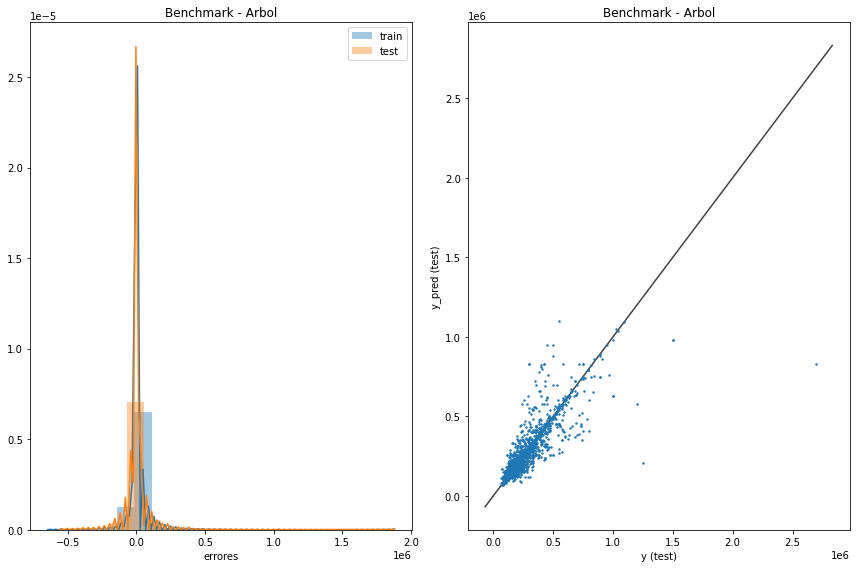

Modelo: KNN
Raíz del error cuadrático medio en Train: 59153.70526011052
Raíz del error cuadrático medio en Test: 71987.02399025446
R2 en Train: 0.8652988340391227
R2 en Test: 0.7931429976595751


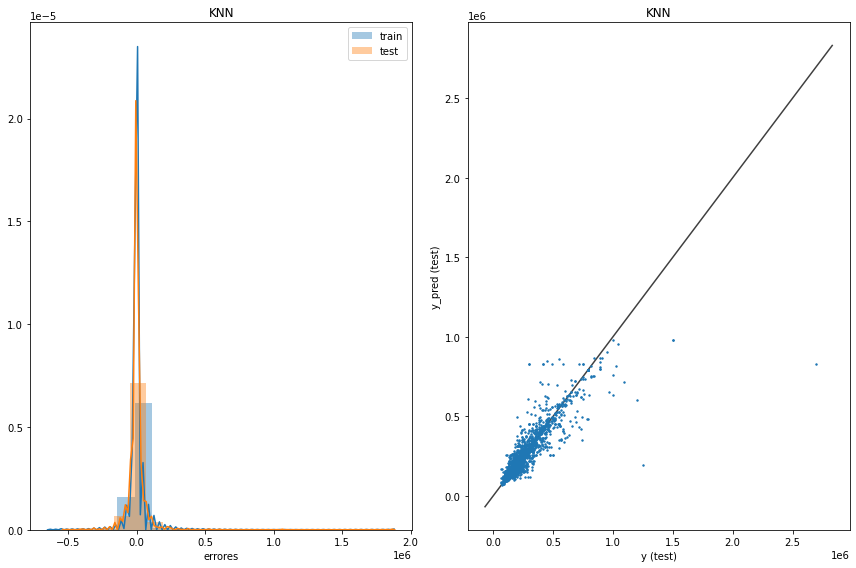

Modelo: XGBoost
Raíz del error cuadrático medio en Train: 79964.7564752906
Raíz del error cuadrático medio en Test: 80595.53426638887
R2 en Train: 0.7538472529983861
R2 en Test: 0.7407112080195006


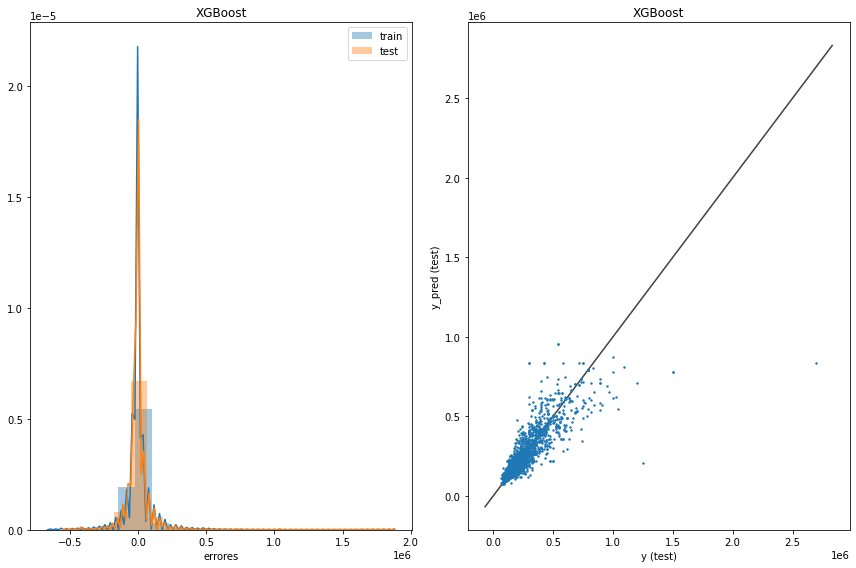

Modelo: RandomForest
Raíz del error cuadrático medio en Train: 69771.16997218065
Raíz del error cuadrático medio en Test: 76553.80931844874
R2 en Train: 0.8126043696099543
R2 en Test: 0.7660648943834545


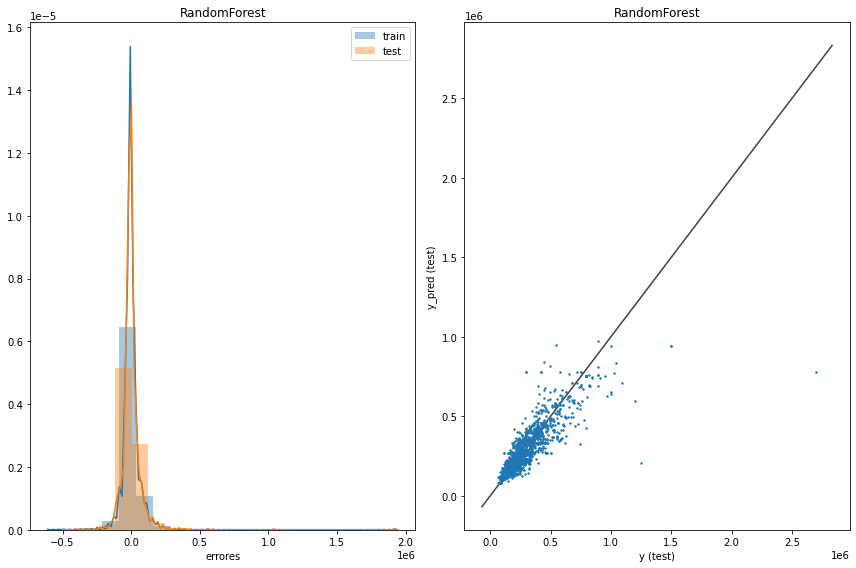

Modelo: ElasticNet
Raíz del error cuadrático medio en Train: 95797.16769371777
Raíz del error cuadrático medio en Test: 95717.1781681457
R2 en Train: 0.646725096105033
R2 en Test: 0.6342860213298218


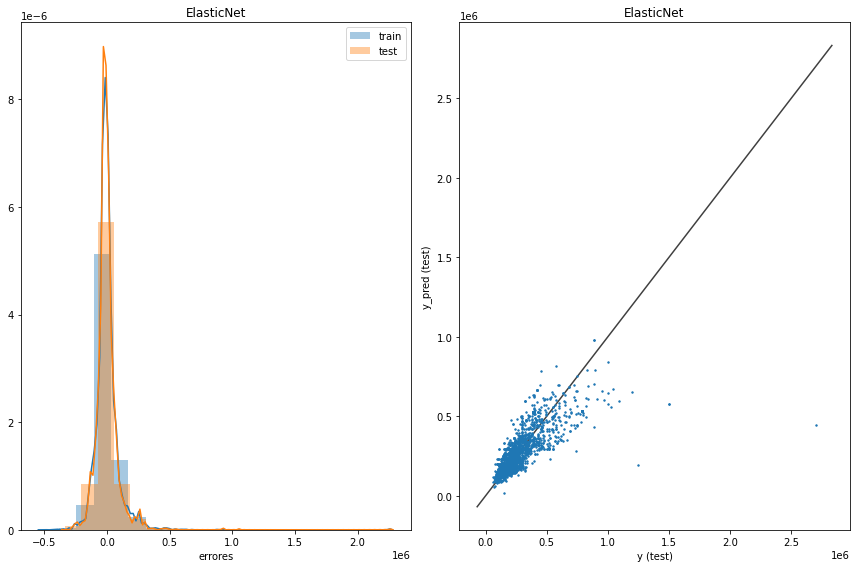

In [158]:
# Graficar los errores y los resultados de los modelos optimizados

modelos = ["Benchmark - Arbol", "KNN", "XGBoost", "RandomForest","ElasticNet"]

for i, model in enumerate([tree_regressor, forest_best, knn_grid, xgb_grid,model_elastic]):
    y_train_pred = model.predict(X_train).reshape(-1, 1)
    y_test_pred = model.predict(X_test).reshape(-1, 1)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R2 en Train: {r2_train}')
    print(f'R2 en Test: {r2_test}')
    
    plt.figure(figsize = (12,8))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.title (modelos[i])
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.title (modelos[i])
    
    plt.tight_layout()
    plt.show();

* Todos los modelos presentan mayor dispersión en los errores a medida que aumenta el precio, eso se debe a lo observado mediante el análisis exploratorio de datos, de la prescencia de una variable precio con amplia dispersión y alta diferencia entre los precios máximos y el valor para el 75% de los datos.
* El modelo de randomforest es el que presenta mayor similitud de las distribuciones de train y test.
* El modelo de ElasticNet es el de peor desempeño, ya que se trata de un modelo de regresión Lineal y este es un tipo de regularización como Ridge y Lasso.

Modelo: Regresión de Ridge
Raíz del error cuadrático medio en Train: 95151.12061930168
Raíz del error cuadrático medio en Test: 95437.48260686373
R2 en Train: 0.6514739344123184
R2 en Test: 0.6364202072628341


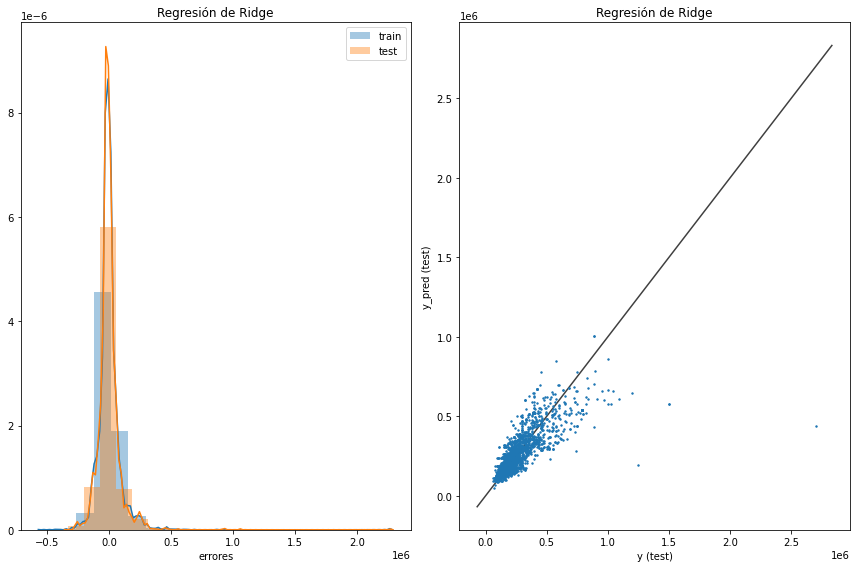

In [159]:
modelos = ["Regresión de Ridge"]

for i, model in enumerate([reg_ridge_best]):
    y_train_pred = model.predict(X_train_poli).reshape(-1, 1)
    y_test_pred = model.predict(X_test_poli).reshape(-1, 1)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R2 en Train: {r2_train}')
    print(f'R2 en Test: {r2_test}')
    
    plt.figure(figsize = (12,8))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.title (modelos[i])
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.title (modelos[i])
    
    plt.tight_layout()
    plt.show();

* En el modelo de Ridge, se observa que la curva de train se encuentra con menor dispersión que la de test y a medida que aumenta el precio se observa que los errores en test tienen mayor dispersión.
* El modelo de Regresión Lineal con regularización utlizado es uno de los que obtiene menor desempeño, ya que no se adapta correctamente porque la variable a predecir (precio) no es normal, y la superficie total que es la variable de mayor relevancia, tiene un alto sesgo. 

# Conclusiones Finales

#### Selección del mejor modelo: 
El mejor modelo es el de RandomForest, que alcanza un RMSE de 71.987 y un R2 de 0.79 en test.
El modelo de XGBBoost presenta menor diferencia entre el RMSE de train y test, pero con un desempeño levemente inferior (RMSE en test 76.553 y R2 0.76)

* Las principales variables que utiliza el modelo para predecir son la superficie total y cubierta, cuales se encuentran correlacionadas entre sí. Era esperado obtener estos resultados, ya que a partir de la matriz de correlaciones de la entrega inicial se había podido observar que estas variables presentan una correlación con la variable precio muy superior al resto de las variables.

* Los modelos de Regresión Lineal con regularización de Ridge y ElastiNet utlizados son los que obtienen menor desempeño, ya que no se adaptan correctamente porque la variable a predecir (precio) no es normal, y la superficie total que es la variable de mayor relevancia, tiene un alto sesgo. Estos modelos presentan una distribución muy similar entre los datos de Entrenamiento y Test.

* A partir de las gráficas de la distribución de las predicciones, se puede observar como todos los modelos presentan mejores predicciones a precios bajos y medios, mientras que todos los modelos presentan mayor distancia en la predicción para precios altos.

### Conclusión general / metodológica:

#### Análisis exploratorio de datos:

Se llevó a cabo un análisis exploratorio del dataset de una Inmobiliaria para las publicaciones de Venta de Capital Federal y Gran Buenos Aires.
Se observó que la mayoría de las publicaciones de la inmobiliaria son departamentos del barrio de Palermo, que a su vez presenta los mayores precios, generando falta de representatividad en los datos disponibles del resto de las categorías de zonas, barrios y tipos de propiedad. En el barrio de Palermo a su vez, la mayoría de las publicaciones son departamentos.
La variable superficie cubierta es la que presenta mayor correlación lineal con el precio de la publicación. Esta variable a su vez, presenta una dispersión significativa de acuerdo al tipo de propiedad, por lo que analizar todos los tipos de propiedad juntos, puede generar distorciones en las predicciones.

*Se concluye que para llevar a cabo las predicciones de precios, es necesario segmentar el dataset por separando el barrio de Palermo del resto de los barrios, como también y dentro del barrio de palermo el tipo de propiedad departamento.
 
Se llevó a cabo un análisis adicional del barrio de Palermo, con el objetivo de analizar otras variables que toma en cuenta el probable comprador. 
*Se pudo determinar que en Palermo es el barrio con mayor cantidad de delitos denunciados de acuerdo al Gobierno de la ciudad de Buenos Aires. A su vez, el precio por metro cuadrado de los terrenos es de un precio entre los 10 más caro de la ciudad, coincidiendo con los valor del precio por metro cuadrado de la inmobiliaria.

#### Algoritmos de predicción:
* Con la optimización de hiperparámetros, se produce una notable reducción en los errores respecto al modelo generado por defecto.
* Se obtuvo un modelo con una buena capacidad de predicción, aunque la misma presenta mayor error a precios mayores.
* Se considera que sería adecudado separar el barrio de Palermo y Belgrano de manera individual y separa entre ellas, ya que se puede observar que ambas features toman una relevancia que puede producir que para el resto de los barrios la predicción sea menos certera.
* El modelo obtiene los resultados esperados, con una mayor importancia de la Feature superficie total y cubierta, lo cual se había podido observar en la primer entrega a través de la alta correlación de estas variables con el precio, mientras que el resto presentaba una correlación inferior.

* El mejor modelo es el de RandomForest, que alcanza un RMSE de 71.987 y un R2 de 0.79 en test.
* El modelo de XGBBoost presenta menor diferencia entre el RMSE de train y test, pero con un desempeño levemente inferior (RMSE en test 76.553 y R2 0.76)

Respecto a los modelos en particular y su distribución de los errores:

* El modelo de Regresión Lineal con regularización utlizado es el que obtiene menor desempeño, ya que no se adapta correctamente porque la variable a predecir (precio) no es normal, y la superficie total que es la variable de mayor relevancia, tiene un alto sesgo. 
* Las principales variables que utiliza el modelo para predecir son la superficie total y cubierta, cuales se encuentra correlacionadas entre sí. Era esperado obtener estos resultados, ya que a partir de la matriz de correlaciones de la entrega inicial se había podido observar que estas variables presentan una correlación con la variable precio muy superior al resto de las variables.
